In [8]:
import pandas as pd
import xgboost as xgb
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, train_test_split, StratifiedKFold
from hyperopt import hp, fmin, tpe, space_eval

import optuna
from sklearn.metrics import f1_score
import tqdm as notebook_tqdm

import time

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity

(590540, 434)


In [4]:
df_train = reduce_mem_usage(df_train)    

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [5]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

cols_to_keep = ['R_emaildomain', 'DeviceInfo', 'DeviceType', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'dist1', 'dist2', 'id_31', 'id_30', 'M5', 'M7', 'M8', 'M9']
cols_to_drop = cols_to_drop.drop(cols_to_keep, errors='ignore') # Exclude 'R_emaildomain' from dropping

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

remove_columns = ['M4']
# Drop these columns
df_train_cleaned = df_train_cleaned.drop(columns=remove_columns)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147',
       ...
       'id_27', 'id_28', 'id_29', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38'],
      dtype='object', length=195)
Shape of the cleaned dataframe: (590540, 238)


In [6]:
df_train_cleaned = df_train_cleaned.drop('TransactionID', axis=1)

# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [7]:
"M9" in df_train.columns

True

In [58]:
df_train[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Matúš\AppData\Lo

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.00,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,0.0,NaN,NaN,0.0,1.561523e+00,0.0,0.0,198.75,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.00,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.00,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.00,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.50,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
pca = PCA(n_components=100)
print("X_train_final shape before PCA:", X_train_final.shape)
X_train_pca = pca.fit_transform(X_train_final)
X_val_pca = pca.transform(X_val)

X_train_final shape before PCA: (472432, 236)


In [69]:
X_train_final.shape

(472432, 236)

In [70]:
X_val_pca.shape

(118108, 100)

In [26]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 8, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.2),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'colsample_bytree': 0.8,
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
    }

    # Print to ensure X_val_pca and y_val are non-empty and correctly shaped
    print(f"Shape of X_val_pca: {X_val_pca.shape}")
    print(f"Shape of y_val: {y_val.shape}")
    print(f"First few values of y_val: {y_val[:5]}")
    
    model = xgb.XGBClassifier(
        **param,
        objective= "binary:logistic",
        random_state=4,
        scale_pos_weight=5,
        early_stopping_rounds=10,  # Stop after 30 rounds with no improvement
        eval_metric="logloss",  # Evaluation metric during training
        verbosity=0
    )
    
    # Fit the model on the training data (with early stopping)
    model.fit(X_train_pca, y_train_final, eval_set=[(X_val_pca, y_val)])

    print(f"Best iteration: {model.best_iteration}")

    # Make predictions on the validation set (using the best iteration)
    y_pred = model.predict(X_val_pca, iteration_range=(0, model.best_iteration))

    # Calculate and return the weighted F1 score
    score = f1_score(y_val, y_pred, average='weighted')
    return score

In [27]:
study = optuna.create_study(study_name="example_xgboost_study", direction='maximize') 

[I 2025-04-12 13:21:14,416] A new study created in memory with name: example_xgboost_study


In [28]:
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)   
best_params = study.best_params
print(f"\nBest parameters: {best_params}")


  0%|          | 0/100 [00:00<?, ?it/s]

Shape of X_val_pca: (118108, 100)Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8

Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027 

Best trial: 13. Best value: 0.975495:   0%|          | 0/100 [03:59<?, ?it/s]

[I 2025-04-12 13:25:27,503] Trial 13 finished with value: 0.9754947121707497 and parameters: {'n_estimators': 142, 'max_depth': 10, 'reg_alpha': 0.09836921865764908, 'reg_lambda': 0.07902157836769415, 'learning_rate': 0.03952108152154869, 'gamma': 0.015690550906354694, 'subsample': 0.8088457423554138}. Best is trial 13 with value: 0.9754947121707497.
[135]	validation_0-logloss:0.08401


Best trial: 13. Best value: 0.975495:   1%|          | 1/100 [03:59<6:34:46, 239.25s/it]

[110]	validation_0-logloss:0.09817
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[197]	validation_0-logloss:0.09857
[115]	validation_0-logloss:0.10972
[136]	validation_0-logloss:0.14830[199]	validation_0-logloss:0.14598

[207]	validation_0-logloss:0.12988
[214]	validation_0-logloss:0.13029
[102]	validation_0-logloss:0.13970
[151]	validation_0-logloss:0.10373
[124]	validation_0-logloss:0.08633
[123]	validation_0-logloss:0.07779
[115]	validation_0-logloss:0.09053
[198]	validation_0-logloss:0.09846
[105]	validation_0-logloss:0.16249
[200]	validation_0-logloss:0.14578
[136]	validation_0-logloss:0.08390
[96]	validation_0-logloss:0.09845
[116]	validation_0-logloss:0.10943
[111]	validation_0-logloss:0.09791
[208]	validation_0-logloss:0.12972
[137]	validation_0-logloss:0.14791
[215]	validation_0-logloss:0.13014
[199]	validation_0-logloss:0.09839
[152]	validation_0-log

Best trial: 12. Best value: 0.977551:   2%|▏         | 2/100 [06:26<5:02:15, 185.05s/it]

[I 2025-04-12 13:27:54,606] Trial 12 finished with value: 0.9775505051871062 and parameters: {'n_estimators': 639, 'max_depth': 11, 'reg_alpha': 0.1437273469083312, 'reg_lambda': 0.074640697270467, 'learning_rate': 0.09046197536356722, 'gamma': 0.048493353255691596, 'subsample': 0.733284349839408}. Best is trial 12 with value: 0.9775505051871062.
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[254]	validation_0-logloss:0.07329
[244]	validation_0-logloss:0.12115
[367]	validation_0-logloss:0.11656
[210]	validation_0-logloss:0.08115
[193]	validation_0-logloss:0.10950
[140]	validation_0-logloss:0.11601
[197]	validation_0-logloss:0.08093
[341]	validation_0-logloss:0.12779
[218]	validation_0-logloss:0.07666
[271]	validation_0-logloss:0.08921
[352]	validation_0-logloss:0.11639
[345]	validation_0-logloss:0.08420
[220]	validation_0-logloss:0.09081
[228]	validation_0-log

Best trial: 12. Best value: 0.977551:   3%|▎         | 3/100 [08:08<3:57:39, 147.01s/it]

[I 2025-04-12 13:29:36,407] Trial 14 finished with value: 0.973980291098172 and parameters: {'n_estimators': 475, 'max_depth': 8, 'reg_alpha': 0.1685685198619941, 'reg_lambda': 0.1433168749084911, 'learning_rate': 0.016068660974709336, 'gamma': 0.06082739298576534, 'subsample': 0.7760928590888208}. Best is trial 12 with value: 0.9775505051871062.
[298]	validation_0-logloss:0.07224
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[458]	validation_0-logloss:0.11086
[262]	validation_0-logloss:0.11410
[450]	validation_0-logloss:0.07800
[324]	validation_0-logloss:0.11120
[305]	validation_0-logloss:0.07095
[287]	validation_0-logloss:0.07503
[342]	validation_0-logloss:0.07117
[71]	validation_0-logloss:0.10516
[297]	validation_0-logloss:0.08400
[444]	validation_0-logloss:0.12090
[358]	validation_0-logloss:0.08264
[252]	validation_0-logloss:0.10286
[264]	validation_0-logl

Best trial: 12. Best value: 0.977551:   3%|▎         | 3/100 [09:14<3:57:39, 147.01s/it]

[I 2025-04-12 13:30:42,499] Trial 9 finished with value: 0.9781633285688203 and parameters: {'n_estimators': 877, 'max_depth': 10, 'reg_alpha': 0.0027249325739448385, 'reg_lambda': 0.14839783914466298, 'learning_rate': 0.08730002102955943, 'gamma': 0.07041068793746881, 'subsample': 0.9876443599355755}. Best is trial 9 with value: 0.9781633285688203.


Best trial: 9. Best value: 0.978163:   4%|▍         | 4/100 [09:14<3:04:06, 115.07s/it] 

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[512]	validation_0-logloss:0.11776
[528]	validation_0-logloss:0.10773
[323]	validation_0-logloss:0.07264
[415]	validation_0-logloss:0.07944
[325]	validation_0-logloss:0.09672
[351]	validation_0-logloss:0.07095
[521]	validation_0-logloss:0.07517
[44]	validation_0-logloss:0.20303
[125]	validation_0-logloss:0.09036
[308]	validation_0-logloss:0.09532
[348]	validation_0-logloss:0.08054
[529]	validation_0-logloss:0.10770
[357]	validation_0-logloss:0.07051
[338]	validation_0-logloss:0.07259
[513]	validation_0-logloss:0.11770
[375]	validation_0-logloss:0.10657
[326]	validation_0-logloss:0.09664
[309]	validation_0-logloss:0.10818
[416]	validation_0-logloss:0.07940
[324]	validation_0-logloss:0.07260
[522]	validation_0-logloss:0.07514
[514]	validation_0-logloss:0.11766
[530]	validation_0-logloss:0.10766
[327]	validation_0-log

Best trial: 9. Best value: 0.978163:   5%|▌         | 5/100 [09:22<2:01:17, 76.61s/it] 

[I 2025-04-12 13:30:50,909] Trial 11 finished with value: 0.974882723544117 and parameters: {'n_estimators': 377, 'max_depth': 10, 'reg_alpha': 0.059700045293608, 'reg_lambda': 0.07562233903992815, 'learning_rate': 0.011515862770271716, 'gamma': 0.1583528466805565, 'subsample': 0.8420638622950329}. Best is trial 9 with value: 0.9781633285688203.
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[520]	validation_0-logloss:0.11738
[313]	validation_0-logloss:0.09489
[422]	validation_0-logloss:0.07910
[131]	validation_0-logloss:0.08914
[314]	validation_0-logloss:0.10763
[357]	validation_0-logloss:0.07084
[50]	validation_0-logloss:0.19686
[334]	validation_0-logloss:0.09603
[529]	validation_0-logloss:0.07482
[329]	validation_0-logloss:0.07240
[363]	validation_0-logloss:0.07053
[537]	validation_0-logloss:0.10733
[521]	validation_0-logloss:0.11735
[354]	validation_0-loglo

[6]	validation_0-logloss:0.21098


Best trial: 9. Best value: 0.978163:   6%|▌         | 6/100 [09:30<1:23:37, 53.38s/it]

[I 2025-04-12 13:30:59,222] Trial 7 finished with value: 0.9780084795695325 and parameters: {'n_estimators': 711, 'max_depth': 11, 'reg_alpha': 0.14613999295938568, 'reg_lambda': 0.10771476976730915, 'learning_rate': 0.05591965231779569, 'gamma': 0.046483368211127266, 'subsample': 0.7878697083647802}. Best is trial 9 with value: 0.9781633285688203.
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[363]	validation_0-logloss:0.07074
[537]	validation_0-logloss:0.07464
[342]	validation_0-logloss:0.09546
[545]	validation_0-logloss:0.10701
[319]	validation_0-logloss:0.09440
[429]	validation_0-logloss:0.07877
[529]	validation_0-logloss:0.11705
[57]	validation_0-logloss:0.19026
[138]	validation_0-logloss:0.08806
[538]	validation_0-logloss:0.07461
[343]	validation_0-logloss:0.09540
[350]	validation_0-logloss:0.07212
[360]	validation_0-logloss:0.07980
[320]	validation_0-lo

Best trial: 9. Best value: 0.978163:   6%|▌         | 6/100 [10:10<1:23:37, 53.38s/it]

[I 2025-04-12 13:31:39,172] Trial 0 finished with value: 0.9781671540065985 and parameters: {'n_estimators': 571, 'max_depth': 8, 'reg_alpha': 0.05376981259310359, 'reg_lambda': 0.16868479293232333, 'learning_rate': 0.0674421767307381, 'gamma': 0.054844076152049115, 'subsample': 0.7508373343019924}. Best is trial 0 with value: 0.9781671540065985.
[380]	validation_0-logloss:0.07133


Best trial: 0. Best value: 0.978167:   7%|▋         | 7/100 [10:10<1:15:57, 49.01s/it]

[387]	validation_0-logloss:0.09234
[463]	validation_0-logloss:0.07721
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[47]	validation_0-logloss:0.12908
[395]	validation_0-logloss:0.07054
[171]	validation_0-logloss:0.08231
[26]	validation_0-logloss:0.17791
[571]	validation_0-logloss:0.11529
[588]	validation_0-logloss:0.10530
[345]	validation_0-logloss:0.09233
[391]	validation_0-logloss:0.07833
[388]	validation_0-logloss:0.09227
[349]	validation_0-logloss:0.10449
[91]	validation_0-logloss:0.16502
[464]	validation_0-logloss:0.07718
[589]	validation_0-logloss:0.10525
[48]	validation_0-logloss:0.12850
[364]	validation_0-logloss:0.07139
[572]	validation_0-logloss:0.11523
[396]	validation_0-logloss:0.07052
[172]	validation_0-logloss:0.08223
[27]	validation_0-logloss:0.17594
[381]	validation_0-logloss:0.07130
[11]	validation_0-logloss:0.21123
[392]	validation_0-logloss:

Best trial: 0. Best value: 0.978167:   8%|▊         | 8/100 [10:45<1:08:13, 44.50s/it]

[I 2025-04-12 13:32:14,072] Trial 3 finished with value: 0.9779758115976663 and parameters: {'n_estimators': 969, 'max_depth': 11, 'reg_alpha': 0.010328566320645695, 'reg_lambda': 0.15104018842064523, 'learning_rate': 0.051282339879653076, 'gamma': 0.13137672249747628, 'subsample': 0.867367027044557}. Best is trial 0 with value: 0.9781671540065985.
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[83]	validation_0-logloss:0.11565
[117]	validation_0-logloss:0.15124
[607]	validation_0-logloss:0.11404
[24]	validation_0-logloss:0.20099
[53]	validation_0-logloss:0.14037
[625]	validation_0-logloss:0.10387
[201]	validation_0-logloss:0.07898
[390]	validation_0-logloss:0.07095
[407]	validation_0-logloss:0.07089
[494]	validation_0-logloss:0.07609
[370]	validation_0-logloss:0.09053
[30]	validation_0-logloss:0.15867
[426]	validation_0-logloss:0.08983
[84]	validation_0-loglos

Best trial: 0. Best value: 0.978167:   8%|▊         | 8/100 [11:10<1:08:13, 44.50s/it]

[I 2025-04-12 13:32:38,516] Trial 6 finished with value: 0.9780237463479561 and parameters: {'n_estimators': 509, 'max_depth': 10, 'reg_alpha': 0.004210788874388904, 'reg_lambda': 0.03632807727762166, 'learning_rate': 0.03251218102648223, 'gamma': 0.07701552591557558, 'subsample': 0.9495779380680933}. Best is trial 0 with value: 0.9781671540065985.
[631]	validation_0-logloss:0.11315


Best trial: 0. Best value: 0.978167:   9%|▉         | 9/100 [11:10<57:59, 38.23s/it]  

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[48]	validation_0-logloss:0.16819
[136]	validation_0-logloss:0.14334
[7]	validation_0-logloss:0.22773
[108]	validation_0-logloss:0.10931
[425]	validation_0-logloss:0.07071
[437]	validation_0-logloss:0.07646
[387]	validation_0-logloss:0.08941
[452]	validation_0-logloss:0.08827
[650]	validation_0-logloss:0.10289
[221]	validation_0-logloss:0.07694
[49]	validation_0-logloss:0.16720
[632]	validation_0-logloss:0.11312
[408]	validation_0-logloss:0.07065
[72]	validation_0-logloss:0.12653
[391]	validation_0-logloss:0.10127
[109]	validation_0-logloss:0.10918
[137]	validation_0-logloss:0.14296
[8]	validation_0-logloss:0.22331
[651]	validation_0-logloss:0.10286
[453]	validation_0-logloss:0.08821
[426]	validation_0-logloss:0.07071
[50]	validation_0-logloss:0.16623
[633]	validation_0-logloss:0.11309
[222]	validation_0-logloss:0.

Best trial: 0. Best value: 0.978167:   9%|▉         | 9/100 [12:42<57:59, 38.23s/it]

[I 2025-04-12 13:34:11,017] Trial 8 finished with value: 0.9741513226313329 and parameters: {'n_estimators': 717, 'max_depth': 8, 'reg_alpha': 0.18359691335936565, 'reg_lambda': 0.10267843186540714, 'learning_rate': 0.011010719373056012, 'gamma': 0.18951513914864832, 'subsample': 0.8942582219647908}. Best is trial 0 with value: 0.9781671540065985.


Best trial: 0. Best value: 0.978167:  10%|█         | 10/100 [12:42<1:22:29, 55.00s/it]

[143]	validation_0-logloss:0.12647
[456]	validation_0-logloss:0.09699
[300]	validation_0-logloss:0.07228
[93]	validation_0-logloss:0.09984
[498]	validation_0-logloss:0.07022
[77]	validation_0-logloss:0.10334
[205]	validation_0-logloss:0.09431
[509]	validation_0-logloss:0.07404
[452]	validation_0-logloss:0.08563
[746]	validation_0-logloss:0.09945
[553]	validation_0-logloss:0.08310[65]	validation_0-logloss:0.11955

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[144]	validation_0-logloss:0.12631
[478]	validation_0-logloss:0.07012
[144]	validation_0-logloss:0.10313
[211]	validation_0-logloss:0.12302
[206]	validation_0-logloss:0.09415
[747]	validation_0-logloss:0.09942
[78]	validation_0-logloss:0.10299
[301]	validation_0-logloss:0.07225
[499]	validation_0-logloss:0.07023
[554]	validation_0-logloss:0.08303
[453]	validation_0-logloss:0.08557
[510]	validation_0-loglos

Best trial: 0. Best value: 0.978167:  11%|█         | 11/100 [12:52<1:00:51, 41.03s/it]

[I 2025-04-12 13:34:20,415] Trial 19 finished with value: 0.976182304387541 and parameters: {'n_estimators': 212, 'max_depth': 8, 'reg_alpha': 0.06351147014959682, 'reg_lambda': 0.12359208456217091, 'learning_rate': 0.077719135620901, 'gamma': 0.016891407226342636, 'subsample': 0.8506384196013418}. Best is trial 0 with value: 0.9781671540065985.
[462]	validation_0-logloss:0.09667
[307]	validation_0-logloss:0.07201Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8

[85]	validation_0-logloss:0.10112
[150]	validation_0-logloss:0.10176
[152]	validation_0-logloss:0.12486[484]	validation_0-logloss:0.07011

[98]	validation_0-logloss:0.09784
[562]	validation_0-logloss:0.08252
[755]	validation_0-logloss:0.09915
[71]	validation_0-logloss:0.11571
[516]	validation_0-logloss:0.07380
[218]	validation_0-logloss:0.12171
[153]	validation_0-logloss:0.12465
[505]	validation_0-logloss

Best trial: 2. Best value: 0.978211:  12%|█▏        | 12/100 [13:01<46:13, 31.52s/it]  

[I 2025-04-12 13:34:30,160] Trial 2 finished with value: 0.9782113140642181 and parameters: {'n_estimators': 994, 'max_depth': 11, 'reg_alpha': 0.1784919557686566, 'reg_lambda': 0.1346796106147786, 'learning_rate': 0.04589686230891886, 'gamma': 0.1566673106871662, 'subsample': 0.9151388782955125}. Best is trial 2 with value: 0.9782113140642181.
[161]	validation_0-logloss:0.12321
[77]	validation_0-logloss:0.11232
[157]	validation_0-logloss:0.10026
[764]	validation_0-logloss:0.09885
[465]	validation_0-logloss:0.08508
[572]	validation_0-logloss:0.08215Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8

[225]	validation_0-logloss:0.12047
[94]	validation_0-logloss:0.09814
[523]	validation_0-logloss:0.07362
[315]	validation_0-logloss:0.07167
[104]	validation_0-logloss:0.09594
[4]	validation_0-logloss:0.25592
[512]	validation_0-logloss:0.07025
[469]	validation_0-logloss:0

Best trial: 2. Best value: 0.978211:  13%|█▎        | 13/100 [13:11<36:12, 24.97s/it]

[I 2025-04-12 13:34:40,078] Trial 5 finished with value: 0.9755996537803617 and parameters: {'n_estimators': 769, 'max_depth': 8, 'reg_alpha': 0.06992827753976479, 'reg_lambda': 0.10019906246793267, 'learning_rate': 0.016773386634396023, 'gamma': 0.10854953455535335, 'subsample': 0.8872771819717246}. Best is trial 2 with value: 0.9782113140642181.
[6]	validation_0-logloss:0.20003
[530]	validation_0-logloss:0.07347
[83]	validation_0-logloss:0.10948
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[12]	validation_0-logloss:0.23527
[475]	validation_0-logloss:0.09587
[582]	validation_0-logloss:0.08174
[472]	validation_0-logloss:0.08479
[171]	validation_0-logloss:0.12167
[103]	validation_0-logloss:0.09605
[165]	validation_0-logloss:0.09906
[323]	validation_0-logloss:0.07140
[110]	validation_0-logloss:0.09425
[233]	validation_0-logloss:0.11918
[531]	validation_0-loglos

Best trial: 2. Best value: 0.978211:  14%|█▍        | 14/100 [13:13<25:46, 17.98s/it]

[I 2025-04-12 13:34:41,903] Trial 1 finished with value: 0.9779021647759604 and parameters: {'n_estimators': 569, 'max_depth': 11, 'reg_alpha': 0.026077990148358057, 'reg_lambda': 0.1735346408083456, 'learning_rate': 0.04096630827394322, 'gamma': 0.14647069488947176, 'subsample': 0.7164633336505164}. Best is trial 2 with value: 0.9782113140642181.
[172]	validation_0-logloss:0.12157
[104]	validation_0-logloss:0.09582
[324]	validation_0-logloss:0.07140Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8

[476]	validation_0-logloss:0.09579
[473]	validation_0-logloss:0.08475
[7]	validation_0-logloss:0.19349
[166]	validation_0-logloss:0.09888
[234]	validation_0-logloss:0.11902
[584]	validation_0-logloss:0.08161
[532]	validation_0-logloss:0.07342
[111]	validation_0-logloss:0.09398
[173]	validation_0-logloss:0.12147
[105]	validation_0-logloss:0.09555
[85]	validation_0-loglo

Best trial: 2. Best value: 0.978211:  15%|█▌        | 15/100 [13:20<20:48, 14.69s/it]

[I 2025-04-12 13:34:48,976] Trial 18 finished with value: 0.9742158044578846 and parameters: {'n_estimators': 237, 'max_depth': 10, 'reg_alpha': 0.07106522727767464, 'reg_lambda': 0.12849242207808473, 'learning_rate': 0.012648331880916327, 'gamma': 0.024228806904491453, 'subsample': 0.8560953966409809}. Best is trial 2 with value: 0.9782113140642181.
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[480]	validation_0-logloss:0.09551
[329]	validation_0-logloss:0.07120
[18]	validation_0-logloss:0.22228
[110]	validation_0-logloss:0.09424
[12]	validation_0-logloss:0.16835
[179]	validation_0-logloss:0.12066
[171]	validation_0-logloss:0.09790
[591]	validation_0-logloss:0.08132
[89]	validation_0-logloss:0.10714
[537]	validation_0-logloss:0.07330
[478]	validation_0-logloss:0.08453
[115]	validation_0-logloss:0.09291
[111]	validation_0-logloss:0.09411
[19]	validation_0-log

[I 2025-04-12 13:36:38,811] Trial 23 finished with value: 0.9760113552879952 and parameters: {'n_estimators': 140, 'max_depth': 11, 'reg_alpha': 0.1906131013383646, 'reg_lambda': 0.18702413839301854, 'learning_rate': 0.03740233910669818, 'gamma': 0.15089658803199238, 'subsample': 0.8062152542907716}. Best is trial 2 with value: 0.9782113140642181.


Best trial: 2. Best value: 0.978211:  16%|█▌        | 16/100 [15:10<1:00:40, 43.34s/it]

[705]	validation_0-logloss:0.07756
[196]	validation_0-logloss:0.07997
[534]	validation_0-logloss:0.09282
Shape of X_val_pca: (118108, 100)[40]	validation_0-logloss:0.16217

Shape of y_val: (118108,)
[98]	validation_0-logloss:0.09785
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[286]	validation_0-logloss:0.11096
[105]	validation_0-logloss:0.13947
[405]	validation_0-logloss:0.06976
[236]	validation_0-logloss:0.09002
[531]	validation_0-logloss:0.08216
[706]	validation_0-logloss:0.07753
[40]	validation_0-logloss:0.16073
[161]	validation_0-logloss:0.08405[287]	validation_0-logloss:0.11089

[197]	validation_0-logloss:0.07990
[99]	validation_0-logloss:0.09753
[707]	validation_0-logloss:0.07750
[406]	validation_0-logloss:0.06977
[106]	validation_0-logloss:0.13906
[19]	validation_0-logloss:0.15909[535]	validation_0-logloss:0.09277

[30]	validation_0-logloss:0.12498
[237]	validation_0-logloss:0.08988
[288]	validation_0-logloss:

Best trial: 2. Best value: 0.978211:  17%|█▋        | 17/100 [15:19<45:38, 32.99s/it]  

[I 2025-04-12 13:36:47,770] Trial 15 finished with value: 0.9779510145945897 and parameters: {'n_estimators': 599, 'max_depth': 11, 'reg_alpha': 0.05942664375492682, 'reg_lambda': 0.14675824681212404, 'learning_rate': 0.027119036825798574, 'gamma': 0.15908490971676964, 'subsample': 0.9554100118733875}. Best is trial 2 with value: 0.9782113140642181.
[105]	validation_0-logloss:0.09619
Shape of X_val_pca: (118108, 100)[166]	validation_0-logloss:0.08351

Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[112]	validation_0-logloss:0.13670
[540]	validation_0-logloss:0.09252
[295]	validation_0-logloss:0.11026
[412]	validation_0-logloss:0.06976
[715]	validation_0-logloss:0.07725
[204]	validation_0-logloss:0.07898
[243]	validation_0-logloss:0.08949
[34]	validation_0-logloss:0.11873
[106]	validation_0-logloss:0.09604
[537]	validation_0-logloss:0.08188
[45]	validation_0-logloss:0.15508
[716]	validation_0-lo

Best trial: 2. Best value: 0.978211:  17%|█▋        | 17/100 [16:50<45:38, 32.99s/it]

[I 2025-04-12 13:38:18,636] Trial 20 finished with value: 0.9765453850415204 and parameters: {'n_estimators': 271, 'max_depth': 10, 'reg_alpha': 0.027776360663735747, 'reg_lambda': 0.06107784207437492, 'learning_rate': 0.03402222995061517, 'gamma': 0.05947890713713147, 'subsample': 0.8042308654738947}. Best is trial 2 with value: 0.9782113140642181.
[378]	validation_0-logloss:0.10473


Best trial: 2. Best value: 0.978211:  18%|█▊        | 18/100 [16:50<1:08:54, 50.41s/it]

[12]	validation_0-logloss:0.22301
[264]	validation_0-logloss:0.07430[791]	validation_0-logloss:0.07513

[60]	validation_0-logloss:0.09646[67]	validation_0-logloss:0.13026

[571]	validation_0-logloss:0.08056
[582]	validation_0-logloss:0.09071
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[168]	validation_0-logloss:0.12177
[15]	validation_0-logloss:0.16478[188]	validation_0-logloss:0.08084
[79]	validation_0-logloss:0.12247

[379]	validation_0-logloss:0.10468
[792]	validation_0-logloss:0.07510
[36]	validation_0-logloss:0.12325
[451]	validation_0-logloss:0.06964
[265]	validation_0-logloss:0.07423
[163]	validation_0-logloss:0.08451
[380]	validation_0-logloss:0.10462
[169]	validation_0-logloss:0.12162
[13]	validation_0-logloss:0.21999
[583]	validation_0-logloss:0.09069
[572]	validation_0-logloss:0.08052
[793]	validation_0-logloss:0.07507
[61]	validation_0-logloss:0.

Best trial: 17. Best value: 0.97838:  19%|█▉        | 19/100 [17:09<55:24, 41.04s/it]  

[I 2025-04-12 13:38:37,941] Trial 17 finished with value: 0.9783797294467749 and parameters: {'n_estimators': 640, 'max_depth': 10, 'reg_alpha': 0.06511445727398027, 'reg_lambda': 0.07266356902601345, 'learning_rate': 0.06594913835514986, 'gamma': 0.07372271915636526, 'subsample': 0.8125230982724316}. Best is trial 17 with value: 0.9783797294467749.
[812]	validation_0-logloss:0.07460[44]	validation_0-logloss:0.11323

[582]	validation_0-logloss:0.08014
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[68]	validation_0-logloss:0.09306
[281]	validation_0-logloss:0.07335
[76]	validation_0-logloss:0.12337
[399]	validation_0-logloss:0.10356
[179]	validation_0-logloss:0.08249
[22]	validation_0-logloss:0.19640
[185]	validation_0-logloss:0.11895
[592]	validation_0-logloss:0.09031
[813]	validation_0-logloss:0.07459
[400]	validation_0-logloss:0.10351
[196]	validation_0-logl

Best trial: 16. Best value: 0.978518:  20%|██        | 20/100 [17:28<45:43, 34.29s/it]

[I 2025-04-12 13:38:56,393] Trial 16 finished with value: 0.9785176682338166 and parameters: {'n_estimators': 819, 'max_depth': 8, 'reg_alpha': 0.07713041048088028, 'reg_lambda': 0.051790808437424674, 'learning_rate': 0.04427255673133668, 'gamma': 0.014776638267358068, 'subsample': 0.9108209441301195}. Best is trial 16 with value: 0.9785176682338166.
[194]	validation_0-logloss:0.08078
[596]	validation_0-logloss:0.09012
[298]	validation_0-logloss:0.07245
[192]	validation_0-logloss:0.11777
[421]	validation_0-logloss:0.10234
[94]	validation_0-logloss:0.11367
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[299]	validation_0-logloss:0.07238
[422]	validation_0-logloss:0.10229
[193]	validation_0-logloss:0.11765[78]	validation_0-logloss:0.12199First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8

[195]	validation_0-logloss:0.08072

[0]	validation_0-logloss:0.26726
[300]	validation_0-logloss:0.07235
[194]	validation_0-log

[I 2025-04-12 13:40:11,121] Trial 25 finished with value: 0.9742033796231491 and parameters: {'n_estimators': 244, 'max_depth': 9, 'reg_alpha': 0.06665627499158827, 'reg_lambda': 0.19002049418515987, 'learning_rate': 0.020395293119719864, 'gamma': 0.11121066098799104, 'subsample': 0.7007475332577021}. Best is trial 16 with value: 0.9785176682338166.
[503]	validation_0-logloss:0.09811


Best trial: 16. Best value: 0.978518:  20%|██        | 20/100 [18:42<45:43, 34.29s/it]

[258]	validation_0-logloss:0.07496


Best trial: 16. Best value: 0.978518:  21%|██        | 21/100 [18:42<1:01:09, 46.45s/it]

[110]	validation_0-logloss:0.10577
[48]	validation_0-logloss:0.16582
[635]	validation_0-logloss:0.08859
[29]	validation_0-logloss:0.18386
[31]	validation_0-logloss:0.12422
[231]	validation_0-logloss:0.07651
[259]	validation_0-logloss:0.07490[82]	validation_0-logloss:0.08781

[362]	validation_0-logloss:0.07046
[636]	validation_0-logloss:0.08856
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[30]	validation_0-logloss:0.18196
[111]	validation_0-logloss:0.10541
[260]	validation_0-logloss:0.07482
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[49]	validation_0-logloss:0.16478
[363]	validation_0-logloss:0.07046
[232]	validation_0-logloss:0.07646
[637]	validation_0-logloss:0.08852
[32]	validation_0-logloss:0.12260
[83]	validation_0-logloss:0.08747
[364]	validation_0-logloss:0.07045
[261]	validation_0-logloss:0.07481
[50]	validation_0-logloss:0.16375
[638]	validation_0-logloss:0.08849
[365]	validation_0-logloss:0.0

[116]	validation_0-logloss:0.10357


Best trial: 16. Best value: 0.978518:  21%|██        | 21/100 [18:57<1:01:09, 46.45s/it]

[I 2025-04-12 13:40:25,268] Trial 22 finished with value: 0.9757580415993122 and parameters: {'n_estimators': 504, 'max_depth': 8, 'reg_alpha': 0.0033723029111671025, 'reg_lambda': 0.09009358170201771, 'learning_rate': 0.027443932216113825, 'gamma': 0.1042820063777936, 'subsample': 0.9890836101763505}. Best is trial 16 with value: 0.9785176682338166.
[88]	validation_0-logloss:0.08634


Best trial: 16. Best value: 0.978518:  22%|██▏       | 22/100 [18:57<47:50, 36.80s/it]  

[61]	validation_0-logloss:0.09987
[33]	validation_0-logloss:0.17645
[239]	validation_0-logloss:0.07584[375]	validation_0-logloss:0.07030

[63]	validation_0-logloss:0.15225
[274]	validation_0-logloss:0.07402
[136]	validation_0-logloss:0.09905
[646]	validation_0-logloss:0.08824
[37]	validation_0-logloss:0.11550
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[376]	validation_0-logloss:0.07030
[89]	validation_0-logloss:0.08608
[117]	validation_0-logloss:0.10318
[64]	validation_0-logloss:0.15149
[275]	validation_0-logloss:0.07396
[240]	validation_0-logloss:0.07574
[34]	validation_0-logloss:0.17476
[647]	validation_0-logloss:0.08822
[377]	validation_0-logloss:0.07029
[137]	validation_0-logloss:0.09881
[65]	validation_0-logloss:0.15074
[62]	validation_0-logloss:0.09929
[276]	validation_0-logloss:0.07391
[38]	validation_0-logloss:0.11431
[378]	validation_0-logloss:0.07

[I 2025-04-12 13:41:42,630] Trial 24 finished with value: 0.9782939003229423 and parameters: {'n_estimators': 665, 'max_depth': 9, 'reg_alpha': 0.0040953943640061, 'reg_lambda': 0.18066646199872596, 'learning_rate': 0.09272250134182036, 'gamma': 0.044575536075145444, 'subsample': 0.7321089156633354}. Best is trial 16 with value: 0.9785176682338166.
[126]	validation_0-logloss:0.12400
[332]	validation_0-logloss:0.07174
[61]	validation_0-logloss:0.13977
[173]	validation_0-logloss:0.09203


Best trial: 16. Best value: 0.978518:  23%|██▎       | 23/100 [20:14<1:02:45, 48.90s/it]

[269]	validation_0-logloss:0.07394
[34]	validation_0-logloss:0.17282
[11]	validation_0-logloss:0.18871
[174]	validation_0-logloss:0.09192
[586]	validation_0-logloss:0.07995
[62]	validation_0-logloss:0.13881
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[270]	validation_0-logloss:0.07389
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[333]	validation_0-logloss:0.07170
[12]	validation_0-logloss:0.18406
[175]	validation_0-logloss:0.09175
[63]	validation_0-logloss:0.13789
[334]	validation_0-logloss:0.07164
[271]	validation_0-logloss:0.07386
[127]	validation_0-logloss:0.12372
[13]	validation_0-logloss:0.17983
[335]	validation_0-logloss:0.07160
[128]	validation_0-logloss:0.12343
[64]	validation_0-logloss:0.13697
[272]	validation_0-logloss:0.07383
[176]	validation_0-logloss:0.09154
[129]	validation_0-logloss:0.12320
[336]	validation_0-logloss:0.07159
[273]	validation_0-logloss:0.07377
[177]	validation_0-logloss:0

[I 2025-04-12 13:43:11,272] Trial 26 finished with value: 0.9787223338414243 and parameters: {'n_estimators': 959, 'max_depth': 9, 'reg_alpha': 0.04235525549146105, 'reg_lambda': 0.19772085448246446, 'learning_rate': 0.09245647569197286, 'gamma': 0.10644988766470814, 'subsample': 0.7015710679516927}. Best is trial 26 with value: 0.9787223338414243.
[735]	validation_0-logloss:0.08532
[84]	validation_0-logloss:0.10815


Best trial: 26. Best value: 0.978722:  24%|██▍       | 24/100 [21:43<1:17:02, 60.82s/it]

[83]	validation_0-logloss:0.08894
[596]	validation_0-logloss:0.07959
[254]	validation_0-logloss:0.10484
[335]	validation_0-logloss:0.07151
[85]	validation_0-logloss:0.10806[736]	validation_0-logloss:0.08531

[84]	validation_0-logloss:0.08875
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[86]	validation_0-logloss:0.10766
[597]	validation_0-logloss:0.07954
[255]	validation_0-logloss:0.10471
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[247]	validation_0-logloss:0.08338
[737]	validation_0-logloss:0.08528[336]	validation_0-logloss:0.07149

[85]	validation_0-logloss:0.08861
[256]	validation_0-logloss:0.10466
[87]	validation_0-logloss:0.10735
[738]	validation_0-logloss:0.08526
[248]	validation_0-logloss:0.08331
[337]	validation_0-logloss:0.07148
[86]	validation_0-logloss:0.08841
[257]	validation_0-logloss:0.10457
[598]	validation_0-logloss:0.07950
[88]	validation_0-logloss:0.10701
[258]	validation_0-logloss:0.

Best trial: 26. Best value: 0.978722:  25%|██▌       | 25/100 [24:07<1:47:32, 86.03s/it]

[I 2025-04-12 13:45:35,970] Trial 21 finished with value: 0.9777837655553572 and parameters: {'n_estimators': 597, 'max_depth': 12, 'reg_alpha': 0.06067102606538302, 'reg_lambda': 0.01690896755918969, 'learning_rate': 0.03570597415573397, 'gamma': 0.07498208839075478, 'subsample': 0.7526393450505642}. Best is trial 26 with value: 0.9787223338414243.
[276]	validation_0-logloss:0.07903
[154]	validation_0-logloss:0.09649[208]	validation_0-logloss:0.07265
[455]	validation_0-logloss:0.09056

[42]	validation_0-logloss:0.16036
[859]	validation_0-logloss:0.08227
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[277]	validation_0-logloss:0.07899
[306]	validation_0-logloss:0.07879
[456]	validation_0-logloss:0.09054
[155]	validation_0-logloss:0.09636[152]	validation_0-logloss:0.09413
[73]	validation_0-logloss:0.09423

[860]	validation_0-logloss:0.08226[209]	validation_0-log

Best trial: 26. Best value: 0.978722:  26%|██▌       | 26/100 [26:30<2:06:56, 102.93s/it]

[I 2025-04-12 13:47:58,492] Trial 32 finished with value: 0.9777975331732319 and parameters: {'n_estimators': 852, 'max_depth': 12, 'reg_alpha': 0.11448943711630749, 'reg_lambda': 0.1975976100599039, 'learning_rate': 0.0624398852534619, 'gamma': 0.10489086435340952, 'subsample': 0.9343543656352445}. Best is trial 26 with value: 0.9787223338414243.
[295]	validation_0-logloss:0.08109
[116]	validation_0-logloss:0.08276
[80]	validation_0-logloss:0.12272[116]	validation_0-logloss:0.10128

[383]	validation_0-logloss:0.07459
[950]	validation_0-logloss:0.08052
[724]	validation_0-logloss:0.07576
[426]	validation_0-logloss:0.07165[11]	validation_0-logloss:0.19054

[167]	validation_0-logloss:0.09392
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[608]	validation_0-logloss:0.08387
[209]	validation_0-logloss:0.08573
[117]	validation_0-logloss:0.10113
[296]	validation_0-logl

Best trial: 26. Best value: 0.978722:  27%|██▋       | 27/100 [27:46<1:55:40, 95.08s/it] 

[I 2025-04-12 13:49:15,286] Trial 10 finished with value: 0.9774887792197511 and parameters: {'n_estimators': 968, 'max_depth': 11, 'reg_alpha': 0.1157105334966061, 'reg_lambda': 0.09319775164092399, 'learning_rate': 0.010608762531751574, 'gamma': 0.14003371350314178, 'subsample': 0.9952300075217009}. Best is trial 26 with value: 0.9787223338414243.
[412]	validation_0-logloss:0.07361[495]	validation_0-logloss:0.07035

[176]	validation_0-logloss:0.09093
[38]	validation_0-logloss:0.12965
[70]	validation_0-logloss:0.09545
[238]	validation_0-logloss:0.07109[18]	validation_0-logloss:0.16360

[238]	validation_0-logloss:0.08263
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[365]	validation_0-logloss:0.07675
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[672]	validation_0-logloss:0.08142
[749]	validation_0-logloss:0.07515
[189]	validation_0-logloss:0.09054
[103]	validation_0-logloss:0.11020
[130]	validation_0-log

[I 2025-04-12 13:50:50,971] Trial 38 finished with value: 0.9786400975726911 and parameters: {'n_estimators': 832, 'max_depth': 9, 'reg_alpha': 0.11450334709712057, 'reg_lambda': 0.016292438562753926, 'learning_rate': 0.0686264879461347, 'gamma': 0.03496703931097901, 'subsample': 0.754938025442266}. Best is trial 26 with value: 0.9787223338414243.
[450]	validation_0-logloss:0.07319
[230]	validation_0-logloss:0.08544
[144]	validation_0-logloss:0.09762
[281]	validation_0-logloss:0.07924


Best trial: 26. Best value: 0.978722:  28%|██▊       | 28/100 [29:22<1:54:21, 95.29s/it]

[765]	validation_0-logloss:0.07828
Best iteration: 266
[134]	validation_0-logloss:0.07946
[125]	validation_0-logloss:0.09784
[791]	validation_0-logloss:0.07410
[262]	validation_0-logloss:0.08167
[466]	validation_0-logloss:0.07202
[60]	validation_0-logloss:0.11534
[105]	validation_0-logloss:0.08477
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[766]	validation_0-logloss:0.07827[451]	validation_0-logloss:0.07314

[54]	validation_0-logloss:0.10523
[231]	validation_0-logloss:0.08537
[263]	validation_0-logloss:0.08157
[61]	validation_0-logloss:0.11499
[23]	validation_0-logloss:0.14068
[126]	validation_0-logloss:0.09759
[145]	validation_0-logloss:0.09736
[767]	validation_0-logloss:0.07825
[106]	validation_0-logloss:0.08457
[467]	validation_0-logloss:0.07199
[282]	validation_0-logloss:0.07911
[452]	validation_0-logloss:0.07310
[792]	validation_0-logloss:0.07405
[264]

Best trial: 26. Best value: 0.978722:  29%|██▉       | 29/100 [29:27<1:20:31, 68.05s/it]

[I 2025-04-12 13:50:55,534] Trial 29 finished with value: 0.9778119303396295 and parameters: {'n_estimators': 935, 'max_depth': 12, 'reg_alpha': 0.11471691107281917, 'reg_lambda': 0.1885129064570204, 'learning_rate': 0.06313671195378884, 'gamma': 0.18746856277308493, 'subsample': 0.9265849647120169}. Best is trial 26 with value: 0.9787223338414243.
[769]	validation_0-logloss:0.07819
[107]	validation_0-logloss:0.08436
[283]	validation_0-logloss:0.07905
[266]	validation_0-logloss:0.08139
[454]	validation_0-logloss:0.07304
[233]	validation_0-logloss:0.08517
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[56]	validation_0-logloss:0.10391
[64]	validation_0-logloss:0.11391
[129]	validation_0-logloss:0.09697
[469]	validation_0-logloss:0.07195
[267]	validation_0-logloss:0.08133
[455]	validation_0-logloss:0.07298
[770]	validation_0-logloss:0.07816
[130]	validation_0-log

[I 2025-04-12 13:52:51,871] Trial 35 finished with value: 0.9782603097405342 and parameters: {'n_estimators': 850, 'max_depth': 9, 'reg_alpha': 0.10002559522997675, 'reg_lambda': 0.0004057831022944436, 'learning_rate': 0.025782507281466638, 'gamma': 0.0016196994194777325, 'subsample': 0.9283776579395984}. Best is trial 26 with value: 0.9787223338414243.
[204]	validation_0-logloss:0.08795
[74]	validation_0-logloss:0.10811


Best trial: 26. Best value: 0.978722:  30%|███       | 30/100 [31:23<1:36:20, 82.58s/it]

[152]	validation_0-logloss:0.09227
[362]	validation_0-logloss:0.07472
[79]	validation_0-logloss:0.10672
[293]	validation_0-logloss:0.08028
[187]	validation_0-logloss:0.07385
[222]	validation_0-logloss:0.08361
[341]	validation_0-logloss:0.07541
[166]	validation_0-logloss:0.07613
[858]	validation_0-logloss:0.07277
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[113]	validation_0-logloss:0.08399
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[76]	validation_0-logloss:0.09079
[75]	validation_0-logloss:0.10786
[548]	validation_0-logloss:0.07057
[363]	validation_0-logloss:0.07467
[80]	validation_0-logloss:0.10641
[153]	validation_0-logloss:0.09208
[205]	validation_0-logloss:0.08785[223]	validation_0-logloss:0.08350

[859]	validation_0-logloss:0.07277
[533]	validation_0-logloss:0.07076
[549]	validation_0-logloss:0.07056
[342]	validation_0-logloss:0.07535
[76]	validation_0-logloss:0.10750
[167]	validation_0-logloss

Best trial: 26. Best value: 0.978722:  30%|███       | 30/100 [33:25<1:36:20, 82.58s/it]

[I 2025-04-12 13:54:53,317] Trial 4 finished with value: 0.978081863085755 and parameters: {'n_estimators': 913, 'max_depth': 11, 'reg_alpha': 0.12883952427726506, 'reg_lambda': 0.13975171627070895, 'learning_rate': 0.016148006606555007, 'gamma': 0.13588448065563116, 'subsample': 0.9211151116594881}. Best is trial 26 with value: 0.9787223338414243.
[169]	validation_0-logloss:0.07604


Best trial: 26. Best value: 0.978722:  31%|███       | 31/100 [33:25<1:48:21, 94.22s/it]

[353]	validation_0-logloss:0.07652
[127]	validation_0-logloss:0.07913
[409]	validation_0-logloss:0.07270
[473]	validation_0-logloss:0.07079
[654]	validation_0-logloss:0.06931
[173]	validation_0-logloss:0.08681[179]	validation_0-logloss:0.08506

[258]	validation_0-logloss:0.07978
[91]	validation_0-logloss:0.10415
[329]	validation_0-logloss:0.07537
[256]	validation_0-logloss:0.08227
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[603]	validation_0-logloss:0.07019
[245]	validation_0-logloss:0.07177
[235]	validation_0-logloss:0.07236
[354]	validation_0-logloss:0.07649
[330]	validation_0-logloss:0.07534
[474]	validation_0-logloss:0.07077
[92]	validation_0-logloss:0.10400
[655]	validation_0-logloss:0.06929
[170]	validation_0-logloss:0.07591
[259]	validation_0-logloss:0.07971
[174]	validation_0-logloss:0.08665
[180]	validation_0-logloss:0.08492
[128]	validation_0-logl

[I 2025-04-12 13:55:35,698] Trial 28 finished with value: 0.9772694638077046 and parameters: {'n_estimators': 325, 'max_depth': 12, 'reg_alpha': 0.19953613591713024, 'reg_lambda': 0.17317842081689316, 'learning_rate': 0.055385717428426094, 'gamma': 0.19344520334522597, 'subsample': 0.7141586814346272}. Best is trial 26 with value: 0.9787223338414243.


Best trial: 26. Best value: 0.978722:  32%|███▏      | 32/100 [34:07<1:29:08, 78.65s/it]

[433]	validation_0-logloss:0.07216
[378]	validation_0-logloss:0.07535
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
[279]	validation_0-logloss:0.08022
[367]	validation_0-logloss:0.07339
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[295]	validation_0-logloss:0.07705
[194]	validation_0-logloss:0.07403
[129]	validation_0-logloss:0.09507[216]	validation_0-logloss:0.08041

[692]	validation_0-logloss:0.06916
[209]	validation_0-logloss:0.08229[512]	validation_0-logloss:0.06998

[257]	validation_0-logloss:0.07190
[631]	validation_0-logloss:0.07012
[151]	validation_0-logloss:0.07624
[434]	validation_0-logloss:0.07215
[130]	validation_0-logloss:0.09493
[20]	validation_0-logloss:0.15443
[379]	validation_0-logloss:0.07530[296]	validation_0-logloss:0.07698

[217]	validation_0-logloss:0.08026
[368]	validation_0-logloss:0.07330
[693]	validation_0-logloss:0.06915
[513]	validation_0-logloss:0.06995
[210]	validation_0-log

Best trial: 39. Best value: 0.978785:  33%|███▎      | 33/100 [34:32<1:09:54, 62.61s/it]

[I 2025-04-12 13:56:00,938] Trial 39 finished with value: 0.978784822798741 and parameters: {'n_estimators': 820, 'max_depth': 9, 'reg_alpha': 0.10055065759684591, 'reg_lambda': 0.0128807543227413, 'learning_rate': 0.06262633682075218, 'gamma': 0.09197104871949072, 'subsample': 0.9270994267190866}. Best is trial 39 with value: 0.978784822798741.
[8]	validation_0-logloss:0.19693
[166]	validation_0-logloss:0.07495
[153]	validation_0-logloss:0.09107
[232]	validation_0-logloss:0.07974[318]	validation_0-logloss:0.07585

[536]	validation_0-logloss:0.06959
[273]	validation_0-logloss:0.07172[391]	validation_0-logloss:0.07248

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[239]	validation_0-logloss:0.07824
[41]	validation_0-logloss:0.12575
[296]	validation_0-logloss:0.07929
[449]	validation_0-logloss:0.07186
[649]	validation_0-logloss:0.07006
[210]	validation_0-logloss

Best trial: 39. Best value: 0.978785:  33%|███▎      | 33/100 [35:16<1:09:54, 62.61s/it]

[I 2025-04-12 13:56:45,256] Trial 37 finished with value: 0.9775489457463652 and parameters: {'n_estimators': 978, 'max_depth': 12, 'reg_alpha': 0.10058453735358733, 'reg_lambda': 0.001344293914927408, 'learning_rate': 0.05531963038473175, 'gamma': 0.18607176618133545, 'subsample': 0.9183969890583641}. Best is trial 39 with value: 0.978784822798741.
[279]	validation_0-logloss:0.07547


Best trial: 39. Best value: 0.978785:  34%|███▍      | 34/100 [35:17<1:02:51, 57.15s/it]

[423]	validation_0-logloss:0.07367[325]	validation_0-logloss:0.07772

[194]	validation_0-logloss:0.08514
[578]	validation_0-logloss:0.06902
[679]	validation_0-logloss:0.07002
[79]	validation_0-logloss:0.10793
[43]	validation_0-logloss:0.12388
[27]	validation_0-logloss:0.14031
[432]	validation_0-logloss:0.07120[237]	validation_0-logloss:0.07213

[358]	validation_0-logloss:0.07377
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[273]	validation_0-logloss:0.07643
[280]	validation_0-logloss:0.07543[476]	validation_0-logloss:0.07134

[195]	validation_0-logloss:0.08507
[579]	validation_0-logloss:0.06901
[80]	validation_0-logloss:0.10775
[195]	validation_0-logloss:0.07303
[326]	validation_0-logloss:0.07764
[424]	validation_0-logloss:0.07364
[433]	validation_0-logloss:0.07115
[680]	validation_0-logloss:0.07002
[44]	validation_0-logloss:0.12311
[28]	validation_0-logloss:

Best trial: 39. Best value: 0.978785:  35%|███▌      | 35/100 [35:48<53:30, 49.39s/it]  

[I 2025-04-12 13:57:16,601] Trial 30 finished with value: 0.978062028874183 and parameters: {'n_estimators': 976, 'max_depth': 12, 'reg_alpha': 0.11433806769960615, 'reg_lambda': 0.19662386915546176, 'learning_rate': 0.025571775100103278, 'gamma': 0.09814546036807677, 'subsample': 0.9183360129345586}. Best is trial 39 with value: 0.978784822798741.
[223]	validation_0-logloss:0.08182
[13]	validation_0-logloss:0.17455
[308]	validation_0-logloss:0.07397[346]	validation_0-logloss:0.07663

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[608]	validation_0-logloss:0.06876
[71]	validation_0-logloss:0.10980
[54]	validation_0-logloss:0.11688
[302]	validation_0-logloss:0.07468
[215]	validation_0-logloss:0.07211
[108]	validation_0-logloss:0.10012
[445]	validation_0-logloss:0.07312
[387]	validation_0-logloss:0.07263
[462]	validation_0-logloss:0.07050
[496]	validation_0-logl

Best trial: 40. Best value: 0.978941:  36%|███▌      | 36/100 [36:35<51:56, 48.70s/it]

[I 2025-04-12 13:58:03,703] Trial 40 finished with value: 0.9789409741592712 and parameters: {'n_estimators': 832, 'max_depth': 9, 'reg_alpha': 0.10344352991738338, 'reg_lambda': 0.04893976205215258, 'learning_rate': 0.06623043371735426, 'gamma': 0.08489810543364643, 'subsample': 0.9264371547616106}. Best is trial 40 with value: 0.9789409741592712.
[477]	validation_0-logloss:0.07227[352]	validation_0-logloss:0.07203

[379]	validation_0-logloss:0.07511
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[246]	validation_0-logloss:0.07131
[98]	validation_0-logloss:0.10272
[286]	validation_0-logloss:0.07126
[55]	validation_0-logloss:0.11705
[348]	validation_0-logloss:0.07237
[432]	validation_0-logloss:0.07106
[508]	validation_0-logloss:0.06986
[150]	validation_0-logloss:0.09120
[115]	validation_0-logloss:0.09810
[33]	validation_0-logloss:0.13286
[269]	validation_0-logl

Best trial: 40. Best value: 0.978941:  37%|███▋      | 37/100 [37:35<54:51, 52.24s/it]

[I 2025-04-12 13:59:04,208] Trial 36 finished with value: 0.9778360436268464 and parameters: {'n_estimators': 975, 'max_depth': 12, 'reg_alpha': 0.1036019246297599, 'reg_lambda': 0.007751440560230312, 'learning_rate': 0.05352000555128237, 'gamma': 0.0015439498194407403, 'subsample': 0.914165251112148}. Best is trial 40 with value: 0.9789409741592712.
[325]	validation_0-logloss:0.07445
[519]	validation_0-logloss:0.07149
[204]	validation_0-logloss:0.08336[489]	validation_0-logloss:0.06989

[406]	validation_0-logloss:0.07067
[410]	validation_0-logloss:0.07073
[90]	validation_0-logloss:0.10484
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[43]	validation_0-logloss:0.12397
[422]	validation_0-logloss:0.07352
[111]	validation_0-logloss:0.09909
[154]	validation_0-logloss:0.09096
[567]	validation_0-logloss:0.06958
[170]	validation_0-logloss:0.08813
[566]	validation_0-l

Best trial: 40. Best value: 0.978941:  38%|███▊      | 38/100 [37:43<40:02, 38.75s/it]

[I 2025-04-12 13:59:11,490] Trial 33 finished with value: 0.9776328655451941 and parameters: {'n_estimators': 991, 'max_depth': 12, 'reg_alpha': 0.10122279576057276, 'reg_lambda': 0.1954414289610466, 'learning_rate': 0.061952955243839126, 'gamma': 0.0996495219970926, 'subsample': 0.9399924301739112}. Best is trial 40 with value: 0.9789409741592712.
[570]	validation_0-logloss:0.07057
[426]	validation_0-logloss:0.07336[49]	validation_0-logloss:0.11994

[117]	validation_0-logloss:0.09758
[210]	validation_0-logloss:0.08277
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[332]	validation_0-logloss:0.07415
[160]	validation_0-logloss:0.08988
[524]	validation_0-logloss:0.07137
[97]	validation_0-logloss:0.10299
[413]	validation_0-logloss:0.07055
[417]	validation_0-logloss:0.07066
[574]	validation_0-logloss:0.06953
[496]	validation_0-logloss:0.06978
[177]	validation_0-log

Best trial: 40. Best value: 0.978941:  38%|███▊      | 38/100 [38:07<40:02, 38.75s/it]

[I 2025-04-12 13:59:36,296] Trial 41 finished with value: 0.9787797051483921 and parameters: {'n_estimators': 842, 'max_depth': 9, 'reg_alpha': 0.08753960767109359, 'reg_lambda': 0.050504811165172664, 'learning_rate': 0.07153599505811013, 'gamma': 0.0021309749605556826, 'subsample': 0.8215783004432136}. Best is trial 40 with value: 0.9789409741592712.
[73]	validation_0-logloss:0.10947


Best trial: 40. Best value: 0.978941:  39%|███▉      | 39/100 [38:07<35:08, 34.56s/it]

[541]	validation_0-logloss:0.07110[11]	validation_0-logloss:0.18235

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[444]	validation_0-logloss:0.07286
[17]	validation_0-logloss:0.16255
[438]	validation_0-logloss:0.07026
[520]	validation_0-logloss:0.06948
[184]	validation_0-logloss:0.08638
[357]	validation_0-logloss:0.07302
[141]	validation_0-logloss:0.09302
[234]	validation_0-logloss:0.08010
[200]	validation_0-logloss:0.08418
[441]	validation_0-logloss:0.07052
[587]	validation_0-logloss:0.07053
[122]	validation_0-logloss:0.09662
[74]	validation_0-logloss:0.10924
[12]	validation_0-logloss:0.17804
[439]	validation_0-logloss:0.07023
[18]	validation_0-logloss:0.15991
[521]	validation_0-logloss:0.06947
[235]	validation_0-logloss:0.08004
[142]	validation_0-logloss:0.09291
[185]	validation_0-logloss:0.08627
[445]	validation_0-logloss:0.07284
[358]	validation_0-logloss

Best trial: 40. Best value: 0.978941:  40%|████      | 40/100 [38:45<35:26, 35.45s/it]

[I 2025-04-12 14:00:13,816] Trial 43 finished with value: 0.9784161044442041 and parameters: {'n_estimators': 863, 'max_depth': 9, 'reg_alpha': 0.08977475120286052, 'reg_lambda': 0.013264876786279219, 'learning_rate': 0.07995012914475186, 'gamma': 0.03208399165966061, 'subsample': 0.701069823006511}. Best is trial 40 with value: 0.9789409741592712.
[109]	validation_0-logloss:0.09914
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[43]	validation_0-logloss:0.12383[268]	validation_0-logloss:0.07738

[218]	validation_0-logloss:0.08194
[158]	validation_0-logloss:0.09029
[25]	validation_0-logloss:0.14269
[234]	validation_0-logloss:0.08003
[49]	validation_0-logloss:0.12061
[556]	validation_0-logloss:0.06920
[393]	validation_0-logloss:0.07189
[175]	validation_0-logloss:0.08764
[476]	validation_0-logloss:0.06990
[472]	validation_0-logloss:0.07212
[110]	validation_0-logl

Best trial: 40. Best value: 0.978941:  40%|████      | 40/100 [38:49<35:26, 35.45s/it]

[I 2025-04-12 14:00:17,856] Trial 27 finished with value: 0.977534178179028 and parameters: {'n_estimators': 874, 'max_depth': 12, 'reg_alpha': 0.06040823906718761, 'reg_lambda': 0.19278410214752573, 'learning_rate': 0.026116997654581527, 'gamma': 0.12409673648311498, 'subsample': 0.7143056996005932}. Best is trial 40 with value: 0.9789409741592712.
[479]	validation_0-logloss:0.06992


Best trial: 40. Best value: 0.978941:  41%|████      | 41/100 [38:49<25:36, 26.04s/it]

[237]	validation_0-logloss:0.07977[52]	validation_0-logloss:0.11890

[178]	validation_0-logloss:0.08714
[113]	validation_0-logloss:0.09832
[570]	validation_0-logloss:0.07078
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[162]	validation_0-logloss:0.08966
[397]	validation_0-logloss:0.07180
[222]	validation_0-logloss:0.08161
[272]	validation_0-logloss:0.07707
[47]	validation_0-logloss:0.12122
[480]	validation_0-logloss:0.06993
[560]	validation_0-logloss:0.06915
[475]	validation_0-logloss:0.07206
[29]	validation_0-logloss:0.13678
[238]	validation_0-logloss:0.07975
[114]	validation_0-logloss:0.09810
[53]	validation_0-logloss:0.11820
[179]	validation_0-logloss:0.08696
[481]	validation_0-logloss:0.06994
[48]	validation_0-logloss:0.12073
[398]	validation_0-logloss:0.07176
[223]	validation_0-logloss:0.08154
[239]	validation_0-logloss:0.07967
[561]	validation_0-logloss

Best trial: 40. Best value: 0.978941:  41%|████      | 41/100 [39:14<25:36, 26.04s/it]

[I 2025-04-12 14:00:43,032] Trial 42 finished with value: 0.9787351659550211 and parameters: {'n_estimators': 833, 'max_depth': 9, 'reg_alpha': 0.08741117067940961, 'reg_lambda': 0.04736014977011441, 'learning_rate': 0.07202778970952273, 'gamma': 0.09377897543942285, 'subsample': 0.9093775691488114}. Best is trial 40 with value: 0.9789409741592712.
[492]	validation_0-logloss:0.07162


Best trial: 40. Best value: 0.978941:  42%|████▏     | 42/100 [39:14<24:54, 25.78s/it]

[76]	validation_0-logloss:0.10925
[245]	validation_0-logloss:0.07946
[16]	validation_0-logloss:0.15184
[186]	validation_0-logloss:0.08638
Shape of X_val_pca: (118108, 100)[71]	validation_0-logloss:0.11029

Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[10]	validation_0-logloss:0.18792
[138]	validation_0-logloss:0.09363
[296]	validation_0-logloss:0.07556
[262]	validation_0-logloss:0.07775
[53]	validation_0-logloss:0.11700
[203]	validation_0-logloss:0.08406[588]	validation_0-logloss:0.07065

[422]	validation_0-logloss:0.07126
[77]	validation_0-logloss:0.10892
[246]	validation_0-logloss:0.07937
[493]	validation_0-logloss:0.07160
[187]	validation_0-logloss:0.08627
[17]	validation_0-logloss:0.14914
[72]	validation_0-logloss:0.10988
[139]	validation_0-logloss:0.09355
[11]	validation_0-logloss:0.18340
[263]	validation_0-logloss:0.07771
[297]	validation_0-logloss:0.07547
[54]	validation_0-logloss:0.11

Best trial: 40. Best value: 0.978941:  43%|████▎     | 43/100 [39:17<17:56, 18.89s/it]

[I 2025-04-12 14:00:45,891] Trial 44 finished with value: 0.978718056152111 and parameters: {'n_estimators': 818, 'max_depth': 9, 'reg_alpha': 0.09113888989483435, 'reg_lambda': 0.0006292493510052302, 'learning_rate': 0.07959130689972303, 'gamma': 0.026804760137819204, 'subsample': 0.7536622801270497}. Best is trial 40 with value: 0.9789409741592712.
[12]	validation_0-logloss:0.17913
[298]	validation_0-logloss:0.07544[264]	validation_0-logloss:0.07765

[55]	validation_0-logloss:0.11604
[79]	validation_0-logloss:0.10850[424]	validation_0-logloss:0.07125

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[205]	validation_0-logloss:0.08388
[189]	validation_0-logloss:0.08594
[74]	validation_0-logloss:0.10948
[248]	validation_0-logloss:0.07920
[19]	validation_0-logloss:0.14444
[141]	validation_0-logloss:0.09321
[590]	validation_0-logloss:0.07064
[13]	validation_0-loglo

Best trial: 40. Best value: 0.978941:  44%|████▍     | 44/100 [40:21<30:16, 32.43s/it]

[I 2025-04-12 14:01:49,907] Trial 45 finished with value: 0.9785235690939974 and parameters: {'n_estimators': 801, 'max_depth': 9, 'reg_alpha': 0.08632792211784754, 'reg_lambda': 0.04213960344610484, 'learning_rate': 0.07704902828215426, 'gamma': 0.08953378859885353, 'subsample': 0.7616513608255505}. Best is trial 40 with value: 0.9789409741592712.
[83]	validation_0-logloss:0.10081
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[52]	validation_0-logloss:0.11249
[543]	validation_0-logloss:0.07082
[326]	validation_0-logloss:0.07371
[137]	validation_0-logloss:0.09449
[204]	validation_0-logloss:0.08349
[73]	validation_0-logloss:0.11000
[49]	validation_0-logloss:0.11239
[141]	validation_0-logloss:0.09442
[310]	validation_0-logloss:0.07502
[361]	validation_0-logloss:0.07222
[254]	validation_0-logloss:0.07871
[120]	validation_0-logloss:0.09656
[268]	validation_0-loglo

Best trial: 40. Best value: 0.978941:  45%|████▌     | 45/100 [41:45<43:45, 47.74s/it]

[I 2025-04-12 14:03:13,359] Trial 34 finished with value: 0.9777371634408827 and parameters: {'n_estimators': 984, 'max_depth': 12, 'reg_alpha': 0.10836118086837287, 'reg_lambda': 0.014816043523190457, 'learning_rate': 0.024217026464592204, 'gamma': 0.09762936570912158, 'subsample': 0.9194938902943848}. Best is trial 40 with value: 0.9789409741592712.
[442]	validation_0-logloss:0.07008
[169]	validation_0-logloss:0.08437
[288]	validation_0-logloss:0.07601
[73]	validation_0-logloss:0.10352
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[155]	validation_0-logloss:0.09176
[350]	validation_0-logloss:0.07305[391]	validation_0-logloss:0.07157

[221]	validation_0-logloss:0.08267
[608]	validation_0-logloss:0.07009
[205]	validation_0-logloss:0.08340
[133]	validation_0-logloss:0.08929
[339]	validation_0-logloss:0.07334
[221]	validation_0-logloss:0.08339
[408]	validation_0

Best trial: 40. Best value: 0.978941:  45%|████▌     | 45/100 [43:36<43:45, 47.74s/it]

[I 2025-04-12 14:05:04,403] Trial 46 finished with value: 0.9787043353422945 and parameters: {'n_estimators': 796, 'max_depth': 9, 'reg_alpha': 0.08625236150250118, 'reg_lambda': 0.04999654452364815, 'learning_rate': 0.07530933845088833, 'gamma': 0.03167591057788601, 'subsample': 0.759788283130316}. Best is trial 40 with value: 0.9789409741592712.
[504]	validation_0-logloss:0.07007


Best trial: 40. Best value: 0.978941:  46%|████▌     | 46/100 [43:36<1:00:03, 66.73s/it]

[289]	validation_0-logloss:0.07418[323]	validation_0-logloss:0.07425

[405]	validation_0-logloss:0.07119
[190]	validation_0-logloss:0.08051
[335]	validation_0-logloss:0.07528
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[103]	validation_0-logloss:0.10217
[457]	validation_0-logloss:0.07021
[269]	validation_0-logloss:0.07866
[248]	validation_0-logloss:0.07578
[332]	validation_0-logloss:0.07431[463]	validation_0-logloss:0.07048

[262]	validation_0-logloss:0.07611


Best trial: 40. Best value: 0.978941:  47%|████▋     | 47/100 [43:37<41:32, 47.02s/it]  

[I 2025-04-12 14:05:05,431] Trial 47 finished with value: 0.9786307664052242 and parameters: {'n_estimators': 802, 'max_depth': 9, 'reg_alpha': 0.03424398275854327, 'reg_lambda': 0.048224908633353776, 'learning_rate': 0.07685466060421148, 'gamma': 0.08718447032061238, 'subsample': 0.7485853091975962}. Best is trial 40 with value: 0.9789409741592712.
[505]	validation_0-logloss:0.07008
[700]	validation_0-logloss:0.06978
[324]	validation_0-logloss:0.07422
[104]	validation_0-logloss:0.10199[406]	validation_0-logloss:0.07119

[191]	validation_0-logloss:0.08045
[290]	validation_0-logloss:0.07411
[336]	validation_0-logloss:0.07517[270]	validation_0-logloss:0.07862

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[458]	validation_0-logloss:0.07020
[263]	validation_0-logloss:0.07608
[249]	validation_0-logloss:0.07572
[464]	validation_0-logloss:0.07047
[333]	validation_0-

Best trial: 40. Best value: 0.978941:  48%|████▊     | 48/100 [43:56<33:38, 38.82s/it]

[I 2025-04-12 14:05:25,124] Trial 31 finished with value: 0.9779971871984273 and parameters: {'n_estimators': 987, 'max_depth': 12, 'reg_alpha': 0.11668242734641285, 'reg_lambda': 0.19528667790469784, 'learning_rate': 0.025069105186385544, 'gamma': 0.1982937623854484, 'subsample': 0.9480051221059816}. Best is trial 40 with value: 0.9789409741592712.
[7]	validation_0-logloss:0.19065
[355]	validation_0-logloss:0.07415
[426]	validation_0-logloss:0.07086
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[524]	validation_0-logloss:0.06998
[478]	validation_0-logloss:0.07002
[344]	validation_0-logloss:0.07318
[211]	validation_0-logloss:0.07844
[268]	validation_0-logloss:0.07456
[289]	validation_0-logloss:0.07719
[351]	validation_0-logloss:0.07347
[483]	validation_0-logloss:0.07030
[311]	validation_0-logloss:0.07322
[283]	validation_0-logloss:0.07493
[9]	validation_0-logl

Best trial: 40. Best value: 0.978941:  49%|████▉     | 49/100 [44:10<26:27, 31.13s/it]

[I 2025-04-12 14:05:38,299] Trial 48 finished with value: 0.9785750796728 and parameters: {'n_estimators': 784, 'max_depth': 9, 'reg_alpha': 0.0822212283204871, 'reg_lambda': 0.040865161917391826, 'learning_rate': 0.07680875159787422, 'gamma': 0.031846121799697556, 'subsample': 0.7620069489157635}. Best is trial 40 with value: 0.9789409741592712.
[357]	validation_0-logloss:0.07268
[19]	validation_0-logloss:0.14406
[224]	validation_0-logloss:0.07724
[368]	validation_0-logloss:0.07372
[439]	validation_0-logloss:0.07061
[363]	validation_0-logloss:0.07293
[495]	validation_0-logloss:0.07025
[3]	validation_0-logloss:0.22202
[19]	validation_0-logloss:0.14449
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[296]	validation_0-logloss:0.07423
[302]	validation_0-logloss:0.07631
[325]	validation_0-logloss:0.07280
[137]	validation_0-logloss:0.09528
[281]	validation_0-logloss

Best trial: 40. Best value: 0.978941:  49%|████▉     | 49/100 [44:31<26:27, 31.13s/it]

[I 2025-04-12 14:06:00,128] Trial 49 finished with value: 0.9784362876965466 and parameters: {'n_estimators': 789, 'max_depth': 9, 'reg_alpha': 0.04071196802246517, 'reg_lambda': 0.042488674782731065, 'learning_rate': 0.07599693271498317, 'gamma': 0.03595425467943246, 'subsample': 0.7560221987446891}. Best is trial 40 with value: 0.9789409741592712.


Best trial: 40. Best value: 0.978941:  50%|█████     | 50/100 [44:31<23:36, 28.34s/it]

[514]	validation_0-logloss:0.06997
[380]	validation_0-logloss:0.07182
[390]	validation_0-logloss:0.07284[462]	validation_0-logloss:0.07034

[25]	validation_0-logloss:0.13415
[384]	validation_0-logloss:0.07215
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[159]	validation_0-logloss:0.09123
[11]	validation_0-logloss:0.17469
[303]	validation_0-logloss:0.07269
[247]	validation_0-logloss:0.07529
[324]	validation_0-logloss:0.07504[348]	validation_0-logloss:0.07183

[39]	validation_0-logloss:0.11942
[320]	validation_0-logloss:0.07336
[381]	validation_0-logloss:0.07177
[515]	validation_0-logloss:0.06995
[39]	validation_0-logloss:0.11944
[463]	validation_0-logloss:0.07033
[391]	validation_0-logloss:0.07278
[26]	validation_0-logloss:0.13282
[12]	validation_0-logloss:0.17081
[160]	validation_0-logloss:0.09109
[385]	validation_0-logloss:0.07213
[304]	validation_0-logloss:

Best trial: 40. Best value: 0.978941:  51%|█████     | 51/100 [44:37<17:40, 21.63s/it]

[I 2025-04-12 14:06:06,120] Trial 50 finished with value: 0.9786348035420842 and parameters: {'n_estimators': 802, 'max_depth': 9, 'reg_alpha': 0.08372925072294427, 'reg_lambda': 0.042876112535981656, 'learning_rate': 0.07617035404283663, 'gamma': 0.032700656946779684, 'subsample': 0.7589003483318926}. Best is trial 40 with value: 0.9789409741592712.
[325]	validation_0-logloss:0.07311
[17]	validation_0-logloss:0.15557[386]	validation_0-logloss:0.07164

[252]	validation_0-logloss:0.07493
[329]	validation_0-logloss:0.07475
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[468]	validation_0-logloss:0.07024
[165]	validation_0-logloss:0.09025
[396]	validation_0-logloss:0.07260
[44]	validation_0-logloss:0.11601
[44]	validation_0-logloss:0.11618
[390]	validation_0-logloss:0.07204
[309]	validation_0-logloss:0.07251
[31]	validation_0-logloss:0.12669
[354]	validation_0-log

Best trial: 40. Best value: 0.978941:  52%|█████▏    | 52/100 [45:37<26:30, 33.14s/it]

[I 2025-04-12 14:07:06,107] Trial 51 finished with value: 0.9789242877036526 and parameters: {'n_estimators': 797, 'max_depth': 9, 'reg_alpha': 0.08295907569636946, 'reg_lambda': 0.03187252086372885, 'learning_rate': 0.07614391298748382, 'gamma': 0.09373087852506273, 'subsample': 0.7560677370061383}. Best is trial 40 with value: 0.9789409741592712.
[373]	validation_0-logloss:0.07069
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[394]	validation_0-logloss:0.07131
[107]	validation_0-logloss:0.09483
[107]	validation_0-logloss:0.09418
[393]	validation_0-logloss:0.07188
[318]	validation_0-logloss:0.07177
[53]	validation_0-logloss:0.13168
[98]	validation_0-logloss:0.09781
[231]	validation_0-logloss:0.08246
[421]	validation_0-logloss:0.07069
[453]	validation_0-logloss:0.07000
[89]	validation_0-logloss:0.10929[66]	validation_0-logloss:0.11814

[461]	validation_0-loglo

Best trial: 40. Best value: 0.978941:  53%|█████▎    | 53/100 [46:37<32:18, 41.24s/it]

[I 2025-04-12 14:08:06,249] Trial 55 finished with value: 0.9789102129215718 and parameters: {'n_estimators': 779, 'max_depth': 9, 'reg_alpha': 0.04688573613410064, 'reg_lambda': 0.03207766164750191, 'learning_rate': 0.09832961836181597, 'gamma': 0.0874291274760688, 'subsample': 0.966733469804937}. Best is trial 40 with value: 0.9789409741592712.
[138]	validation_0-logloss:0.10199
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[384]	validation_0-logloss:0.07040
[170]	validation_0-logloss:0.08291
[161]	validation_0-logloss:0.09578
[463]	validation_0-logloss:0.07066
[457]	validation_0-logloss:0.07018
[439]	validation_0-logloss:0.06983
[297]	validation_0-logloss:0.07719
[61]	validation_0-logloss:0.11756
[118]	validation_0-logloss:0.10778
[170]	validation_0-logloss:0.08311
[519]	validation_0-logloss:0.06945
[526]	validation_0-logloss:0.06998
[166]	validation_0-logl

Best trial: 40. Best value: 0.978941:  54%|█████▍    | 54/100 [46:39<22:35, 29.47s/it]

[I 2025-04-12 14:08:08,258] Trial 52 finished with value: 0.9786299423149148 and parameters: {'n_estimators': 782, 'max_depth': 9, 'reg_alpha': 0.08260376335815073, 'reg_lambda': 0.029256312615981862, 'learning_rate': 0.07489654162104055, 'gamma': 0.11956765143891088, 'subsample': 0.7538934963465844}. Best is trial 40 with value: 0.9789409741592712.
[63]	validation_0-logloss:0.11703
Shape of X_val_pca: (118108, 100)[163]	validation_0-logloss:0.09545

Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[386]	validation_0-logloss:0.07039
[141]	validation_0-logloss:0.10163
[459]	validation_0-logloss:0.07015[528]	validation_0-logloss:0.06997

[120]	validation_0-logloss:0.10747
[172]	validation_0-logloss:0.08262
[465]	validation_0-logloss:0.07066
[441]	validation_0-logloss:0.06983
[299]	validation_0-logloss:0.07711
[521]	validation_0-logloss:0.06943
[172]	validation_0-logloss:0.08289
[168]	validation_0-l

Best trial: 40. Best value: 0.978941:  54%|█████▍    | 54/100 [46:57<22:35, 29.47s/it]

[I 2025-04-12 14:08:25,479] Trial 54 finished with value: 0.9788320483394447 and parameters: {'n_estimators': 773, 'max_depth': 9, 'reg_alpha': 0.041179086434724795, 'reg_lambda': 0.03528728442539916, 'learning_rate': 0.07767670267744456, 'gamma': 0.1207259012737495, 'subsample': 0.8759019905165727}. Best is trial 40 with value: 0.9789409741592712.


Best trial: 40. Best value: 0.978941:  55%|█████▌    | 55/100 [46:57<19:20, 25.79s/it]

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[11]	validation_0-logloss:0.20965
[183]	validation_0-logloss:0.09242
[161]	validation_0-logloss:0.09821
[477]	validation_0-logloss:0.06991
[83]	validation_0-logloss:0.11081
[404]	validation_0-logloss:0.07023
[138]	validation_0-logloss:0.10430
[546]	validation_0-logloss:0.06982
[459]	validation_0-logloss:0.06971
[189]	validation_0-logloss:0.08079
[7]	validation_0-logloss:0.22439
[317]	validation_0-logloss:0.07603
[190]	validation_0-logloss:0.08053
[186]	validation_0-logloss:0.08154
[12]	validation_0-logloss:0.20605
[162]	validation_0-logloss:0.09801
[84]	validation_0-logloss:0.11057
[184]	validation_0-logloss:0.09226
[478]	validation_0-logloss:0.06989
[405]	validation_0-logloss:0.07023
[547]	validation_0-logloss:0.06982
[460]	validation_0-logloss:0.06973[139]	validation_0-logloss:0.10419

[318]	validation_0-logloss:

Best trial: 40. Best value: 0.978941:  56%|█████▌    | 56/100 [46:59<13:39, 18.62s/it]

[I 2025-04-12 14:08:27,344] Trial 58 finished with value: 0.9786459631279201 and parameters: {'n_estimators': 765, 'max_depth': 9, 'reg_alpha': 0.04115638717304718, 'reg_lambda': 0.03265515542304168, 'learning_rate': 0.09776560988495345, 'gamma': 0.09190468668334881, 'subsample': 0.970722833677689}. Best is trial 40 with value: 0.9789409741592712.
[185]	validation_0-logloss:0.09214
[163]	validation_0-logloss:0.09790
[190]	validation_0-logloss:0.08064
[191]	validation_0-logloss:0.08044[85]	validation_0-logloss:0.11036

[187]	validation_0-logloss:0.08137
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[479]	validation_0-logloss:0.06989
[406]	validation_0-logloss:0.07023
[461]	validation_0-logloss:0.06972
[548]	validation_0-logloss:0.06981
[9]	validation_0-logloss:0.21572
[14]	validation_0-logloss:0.19956
[140]	validation_0-logloss:0.10398
[186]	validation_0-loglos

Best trial: 40. Best value: 0.978941:  57%|█████▋    | 57/100 [47:11<12:02, 16.80s/it]

[I 2025-04-12 14:08:39,906] Trial 57 finished with value: 0.9786969776645886 and parameters: {'n_estimators': 774, 'max_depth': 9, 'reg_alpha': 0.03673806132724525, 'reg_lambda': 0.03183519296495514, 'learning_rate': 0.09894876754362975, 'gamma': 0.08801330620301022, 'subsample': 0.9625005418644873}. Best is trial 40 with value: 0.9789409741592712.
[4]	validation_0-logloss:0.24060
[200]	validation_0-logloss:0.09030[492]	validation_0-logloss:0.06969
[28]	validation_0-logloss:0.16736

[100]	validation_0-logloss:0.10633
[152]	validation_0-logloss:0.10197
[6]	validation_0-logloss:0.19978
[419]	validation_0-logloss:0.07025
[23]	validation_0-logloss:0.17512
[201]	validation_0-logloss:0.08008
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[561]	validation_0-logloss:0.06970
[205]	validation_0-logloss:0.07911
[332]	validation_0-logloss:0.07517
[204]	validation_0-logloss

Best trial: 40. Best value: 0.978941:  57%|█████▋    | 57/100 [47:16<12:02, 16.80s/it]

[I 2025-04-12 14:08:45,215] Trial 59 finished with value: 0.9784640221353432 and parameters: {'n_estimators': 724, 'max_depth': 9, 'reg_alpha': 0.041024235141998024, 'reg_lambda': 0.02667257742836482, 'learning_rate': 0.09773467852843483, 'gamma': 0.08720877278504816, 'subsample': 0.8821367216262819}. Best is trial 40 with value: 0.9789409741592712.
[210]	validation_0-logloss:0.07855


Best trial: 40. Best value: 0.978941:  58%|█████▊    | 58/100 [47:16<09:20, 13.35s/it]

[34]	validation_0-logloss:0.15853
[12]	validation_0-logloss:0.16955[29]	validation_0-logloss:0.16424

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[185]	validation_0-logloss:0.09487
[337]	validation_0-logloss:0.07485
[209]	validation_0-logloss:0.07859
[567]	validation_0-logloss:0.06965
[498]	validation_0-logloss:0.06962
[158]	validation_0-logloss:0.10085
[207]	validation_0-logloss:0.07959
[207]	validation_0-logloss:0.08949
[11]	validation_0-logloss:0.21035
[107]	validation_0-logloss:0.10482
[35]	validation_0-logloss:0.15725
[30]	validation_0-logloss:0.16263
[211]	validation_0-logloss:0.07845
[13]	validation_0-logloss:0.16582
[186]	validation_0-logloss:0.09463
[338]	validation_0-logloss:0.07483
[159]	validation_0-logloss:0.10068
[210]	validation_0-logloss:0.07851
[499]	validation_0-logloss:0.06961
[12]	validation_0-logloss:0.20673
[568]	validation_0-logloss:0.

Best trial: 40. Best value: 0.978941:  58%|█████▊    | 58/100 [47:50<09:20, 13.35s/it]

[I 2025-04-12 14:09:18,982] Trial 53 finished with value: 0.9788105932174417 and parameters: {'n_estimators': 780, 'max_depth': 9, 'reg_alpha': 0.08451414473044361, 'reg_lambda': 0.028698779253484966, 'learning_rate': 0.07678387624339393, 'gamma': 0.09031691361603739, 'subsample': 0.9670988261455745}. Best is trial 40 with value: 0.9789409741592712.
[244]	validation_0-logloss:0.07570
[74]	validation_0-logloss:0.12999
[148]	validation_0-logloss:0.09768


Best trial: 40. Best value: 0.978941:  59%|█████▉    | 59/100 [47:50<13:18, 19.48s/it]

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[226]	validation_0-logloss:0.08993
[248]	validation_0-logloss:0.08520
[245]	validation_0-logloss:0.07620
[35]	validation_0-logloss:0.15624
[374]	validation_0-logloss:0.07310
[195]	validation_0-logloss:0.09531
[53]	validation_0-logloss:0.11992
[534]	validation_0-logloss:0.06929
[31]	validation_0-logloss:0.16193
[53]	validation_0-logloss:0.14140
[75]	validation_0-logloss:0.12966
[246]	validation_0-logloss:0.07543
[149]	validation_0-logloss:0.09749
[69]	validation_0-logloss:0.13120
[245]	validation_0-logloss:0.07564
[227]	validation_0-logloss:0.08980
[36]	validation_0-logloss:0.15501
[249]	validation_0-logloss:0.08506
[54]	validation_0-logloss:0.11950
[375]	validation_0-logloss:0.07308
[32]	validation_0-logloss:0.16049
[246]	validation_0-logloss:0.07607
[196]	validation_0-logloss:0.09520
[76]	validation_0-logloss:0.12

Best trial: 40. Best value: 0.978941:  60%|██████    | 60/100 [48:15<13:57, 20.95s/it]

[I 2025-04-12 14:09:43,345] Trial 56 finished with value: 0.9788215438299073 and parameters: {'n_estimators': 753, 'max_depth': 9, 'reg_alpha': 0.03155821289139722, 'reg_lambda': 0.02748881171437479, 'learning_rate': 0.07532173504711442, 'gamma': 0.08649272160540934, 'subsample': 0.8851911969751982}. Best is trial 40 with value: 0.9789409741592712.
[82]	validation_0-logloss:0.11082
[400]	validation_0-logloss:0.07215
[96]	validation_0-logloss:0.12237
[221]	validation_0-logloss:0.09220
[104]	validation_0-logloss:0.12117
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[82]	validation_0-logloss:0.12781
[277]	validation_0-logloss:0.08252
[272]	validation_0-logloss:0.07432
[178]	validation_0-logloss:0.09261
[270]	validation_0-logloss:0.07410
[255]	validation_0-logloss:0.08678
[60]	validation_0-logloss:0.13598
[63]	validation_0-logloss:0.13450
[83]	validation_0-logloss

Best trial: 40. Best value: 0.978941:  61%|██████    | 61/100 [50:38<37:35, 57.84s/it]

[I 2025-04-12 14:12:07,267] Trial 62 finished with value: 0.9787840076539048 and parameters: {'n_estimators': 915, 'max_depth': 9, 'reg_alpha': 0.12730337862389768, 'reg_lambda': 0.028335874520452893, 'learning_rate': 0.09824857906296197, 'gamma': 0.11620085556000455, 'subsample': 0.8847812506992242}. Best is trial 40 with value: 0.9789409741592712.
[455]	validation_0-logloss:0.07338
[359]	validation_0-logloss:0.07613
[384]	validation_0-logloss:0.07896
[433]	validation_0-logloss:0.07584
[288]	validation_0-logloss:0.09862
Shape of X_val_pca: (118108, 100)[266]	validation_0-logloss:0.08302

Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[272]	validation_0-logloss:0.09895
[563]	validation_0-logloss:0.06954[267]	validation_0-logloss:0.09947

[239]	validation_0-logloss:0.10107
[113]	validation_0-logloss:0.10101
[242]	validation_0-logloss:0.10158
[137]	validation_0-logloss:0.09534
[360]	validation_0-

Best trial: 40. Best value: 0.978941:  62%|██████▏   | 62/100 [50:40<26:01, 41.09s/it]

[I 2025-04-12 14:12:09,274] Trial 63 finished with value: 0.9784552652960355 and parameters: {'n_estimators': 758, 'max_depth': 9, 'reg_alpha': 0.04592464740317893, 'reg_lambda': 0.029228758943479267, 'learning_rate': 0.09729230188999137, 'gamma': 0.11897244097062509, 'subsample': 0.8837638934555784}. Best is trial 40 with value: 0.9789409741592712.
[435]	validation_0-logloss:0.07573
[386]	validation_0-logloss:0.07886[290]	validation_0-logloss:0.09840

[268]	validation_0-logloss:0.08282
[274]	validation_0-logloss:0.09885
[138]	validation_0-logloss:0.09512[114]	validation_0-logloss:0.10065

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[269]	validation_0-logloss:0.09927
[244]	validation_0-logloss:0.10145
[565]	validation_0-logloss:0.06955
[241]	validation_0-logloss:0.10088
[458]	validation_0-logloss:0.07326
[362]	validation_0-logloss:0.07599
[436]	validation_0-

Best trial: 40. Best value: 0.978941:  63%|██████▎   | 63/100 [50:42<18:03, 29.29s/it]

[I 2025-04-12 14:12:11,040] Trial 61 finished with value: 0.9785062209385551 and parameters: {'n_estimators': 917, 'max_depth': 9, 'reg_alpha': 0.04272954852417273, 'reg_lambda': 0.027075688263148913, 'learning_rate': 0.09947697809334444, 'gamma': 0.11959627056025686, 'subsample': 0.8794290657935625}. Best is trial 40 with value: 0.9789409741592712.
[437]	validation_0-logloss:0.07571
[292]	validation_0-logloss:0.09821
[270]	validation_0-logloss:0.08265
[388]	validation_0-logloss:0.07878
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[276]	validation_0-logloss:0.09867
[246]	validation_0-logloss:0.10132
[271]	validation_0-logloss:0.09916
[243]	validation_0-logloss:0.10065
[460]	validation_0-logloss:0.07319
[364]	validation_0-logloss:0.07586
[116]	validation_0-logloss:0.10031
[438]	validation_0-logloss:0.07563
[567]	validation_0-logloss:0.06954
[271]	validation_0-

Best trial: 40. Best value: 0.978941:  64%|██████▍   | 64/100 [51:03<15:58, 26.63s/it]

[I 2025-04-12 14:12:31,469] Trial 60 finished with value: 0.9788569554670659 and parameters: {'n_estimators': 747, 'max_depth': 9, 'reg_alpha': 0.04395382225046725, 'reg_lambda': 0.029075058859697123, 'learning_rate': 0.07203541040964682, 'gamma': 0.1184800127254456, 'subsample': 0.8927949896057032}. Best is trial 40 with value: 0.9789409741592712.
[389]	validation_0-logloss:0.07472
[267]	validation_0-logloss:0.09832[484]	validation_0-logloss:0.07250

[300]	validation_0-logloss:0.09656
[296]	validation_0-logloss:0.08067
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[271]	validation_0-logloss:0.09874
[318]	validation_0-logloss:0.09617
[9]	validation_0-logloss:0.20945
[462]	validation_0-logloss:0.07480
[13]	validation_0-logloss:0.20347
[411]	validation_0-logloss:0.07760
[18]	validation_0-logloss:0.18659
[135]	validation_0-logloss:0.09683
[297]	validation_0-loglo

Best trial: 40. Best value: 0.978941:  65%|██████▌   | 65/100 [53:45<39:12, 67.23s/it]

[I 2025-04-12 14:15:13,402] Trial 64 finished with value: 0.9789267288538005 and parameters: {'n_estimators': 731, 'max_depth': 8, 'reg_alpha': 0.05004551368656406, 'reg_lambda': 0.027610502348768367, 'learning_rate': 0.09772931881655264, 'gamma': 0.11918912296078871, 'subsample': 0.9683702806194024}. Best is trial 40 with value: 0.9789409741592712.
[315]	validation_0-logloss:0.07716[207]	validation_0-logloss:0.10558
[192]	validation_0-logloss:0.10700

[505]	validation_0-logloss:0.07146
[505]	validation_0-logloss:0.08352
[595]	validation_0-logloss:0.07114
[468]	validation_0-logloss:0.08419
[478]	validation_0-logloss:0.08437
[289]	validation_0-logloss:0.07852
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[526]	validation_0-logloss:0.08363
[155]	validation_0-logloss:0.09324
[499]	validation_0-logloss:0.08454
[595]	validation_0-logloss:0.06979
[666]	validation_0-

Best trial: 40. Best value: 0.978941:  66%|██████▌   | 66/100 [54:10<31:02, 54.78s/it]

[I 2025-04-12 14:15:39,158] Trial 67 finished with value: 0.978782416644365 and parameters: {'n_estimators': 912, 'max_depth': 8, 'reg_alpha': 0.1299335793210398, 'reg_lambda': 0.03048249975424575, 'learning_rate': 0.09880584096712307, 'gamma': 0.11812716534189917, 'subsample': 0.8856214697477242}. Best is trial 40 with value: 0.9789409741592712.
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[530]	validation_0-logloss:0.08306
[698]	validation_0-logloss:0.06995
[511]	validation_0-logloss:0.08264
[559]	validation_0-logloss:0.08225
[500]	validation_0-logloss:0.08261
[539]	validation_0-logloss:0.07073
[20]	validation_0-logloss:0.15463
[263]	validation_0-logloss:0.09991
[180]	validation_0-logloss:0.08957
[625]	validation_0-logloss:0.07054
[538]	validation_0-logloss:0.08210
[225]	validation_0-logloss:0.10298
[239]	validation_0-logloss:0.10232
[314]	validation_0-logl

Best trial: 40. Best value: 0.978941:  66%|██████▌   | 66/100 [54:43<31:02, 54.78s/it]

[I 2025-04-12 14:16:11,650] Trial 65 finished with value: 0.9788338335861673 and parameters: {'n_estimators': 734, 'max_depth': 8, 'reg_alpha': 0.13142737806001062, 'reg_lambda': 0.02840783244649399, 'learning_rate': 0.08671530594958528, 'gamma': 0.12010008771694933, 'subsample': 0.9742900772861489}. Best is trial 40 with value: 0.9789409741592712.
[305]	validation_0-logloss:0.09616


Best trial: 40. Best value: 0.978941:  67%|██████▋   | 67/100 [54:43<26:27, 48.10s/it]

[278]	validation_0-logloss:0.09879
[345]	validation_0-logloss:0.07496
[372]	validation_0-logloss:0.07418[540]	validation_0-logloss:0.08090

[570]	validation_0-logloss:0.08133
[30]	validation_0-logloss:0.13947
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[581]	validation_0-logloss:0.07017
[210]	validation_0-logloss:0.08564
[601]	validation_0-logloss:0.08066
[663]	validation_0-logloss:0.06996
[553]	validation_0-logloss:0.08078
[580]	validation_0-logloss:0.08030[60]	validation_0-logloss:0.12036

[267]	validation_0-logloss:0.09912
[306]	validation_0-logloss:0.09612
[279]	validation_0-logloss:0.09870
[541]	validation_0-logloss:0.08085
[346]	validation_0-logloss:0.07492
[571]	validation_0-logloss:0.08131
[582]	validation_0-logloss:0.07017
[373]	validation_0-logloss:0.07417
[31]	validation_0-logloss:0.13844
[602]	validation_0-logloss:0.08062
[554]	validation_0-loglo

Best trial: 70. Best value: 0.979208:  68%|██████▊   | 68/100 [55:24<24:33, 46.04s/it]

[I 2025-04-12 14:16:52,896] Trial 70 finished with value: 0.9792079747017325 and parameters: {'n_estimators': 731, 'max_depth': 8, 'reg_alpha': 0.019033151976288666, 'reg_lambda': 0.026650255432413908, 'learning_rate': 0.09964804500890909, 'gamma': 0.0823902856010582, 'subsample': 0.9676781610519796}. Best is trial 70 with value: 0.9792079747017325.
[328]	validation_0-logloss:0.09448
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[250]	validation_0-logloss:0.08227
[654]	validation_0-logloss:0.07895
[591]	validation_0-logloss:0.07874
[386]	validation_0-logloss:0.07311
[621]	validation_0-logloss:0.07951
[710]	validation_0-logloss:0.06939
[605]	validation_0-logloss:0.07874
[360]	validation_0-logloss:0.09215
[413]	validation_0-logloss:0.07273
[111]	validation_0-logloss:0.10684
[633]	validation_0-logloss:0.07830
[39]	validation_0-logloss:0.13099
[82]	validation_0-lo

Best trial: 70. Best value: 0.979208:  69%|██████▉   | 69/100 [56:29<26:39, 51.60s/it]

[I 2025-04-12 14:17:57,482] Trial 68 finished with value: 0.9781995499784946 and parameters: {'n_estimators': 732, 'max_depth': 8, 'reg_alpha': 0.13989481595628128, 'reg_lambda': 0.028263035347387055, 'learning_rate': 0.04701948882035956, 'gamma': 0.12307249023840178, 'subsample': 0.9653440662445978}. Best is trial 70 with value: 0.9792079747017325.
[670]	validation_0-logloss:0.07606
[686]	validation_0-logloss:0.07593
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[313]	validation_0-logloss:0.07771
[716]	validation_0-logloss:0.07560
[400]	validation_0-logloss:0.08878
[784]	validation_0-logloss:0.06874
[407]	validation_0-logloss:0.08890
[701]	validation_0-logloss:0.07713
[446]	validation_0-logloss:0.08692
[191]	validation_0-logloss:0.09331
[164]	validation_0-logloss:0.09711
[119]	validation_0-logloss:0.10500
[72]	validation_0-logloss:0.11677
[671]	validation_0-l

Best trial: 70. Best value: 0.979208:  70%|███████   | 70/100 [56:44<20:18, 40.60s/it]

[I 2025-04-12 14:18:12,423] Trial 71 finished with value: 0.9785450184788311 and parameters: {'n_estimators': 730, 'max_depth': 8, 'reg_alpha': 0.1329254738105258, 'reg_lambda': 0.027002716808398105, 'learning_rate': 0.04615042430294209, 'gamma': 0.08351289923564852, 'subsample': 0.8768467787446987}. Best is trial 70 with value: 0.9792079747017325.
[90]	validation_0-logloss:0.11227
[418]	validation_0-logloss:0.08754
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[137]	validation_0-logloss:0.10171
[182]	validation_0-logloss:0.09441
[465]	validation_0-logloss:0.08615
[719]	validation_0-logloss:0.07658
[209]	validation_0-logloss:0.09132
[491]	validation_0-logloss:0.07090
[463]	validation_0-logloss:0.07084
[8]	validation_0-logloss:0.19308
[801]	validation_0-logloss:0.06867
[689]	validation_0-logloss:0.07554
[425]	validation_0-logloss:0.08778
[705]	validation_0-logl

Best trial: 70. Best value: 0.979208:  70%|███████   | 70/100 [57:03<20:18, 40.60s/it]

[I 2025-04-12 14:18:31,690] Trial 72 finished with value: 0.9786895352441726 and parameters: {'n_estimators': 707, 'max_depth': 8, 'reg_alpha': 0.01828154779004869, 'reg_lambda': 0.057305595416742156, 'learning_rate': 0.04809096578652793, 'gamma': 0.0656702132251157, 'subsample': 0.8879021673401596}. Best is trial 70 with value: 0.9792079747017325.


Best trial: 70. Best value: 0.979208:  71%|███████   | 71/100 [57:03<16:31, 34.21s/it]

[13]	validation_0-logloss:0.17339
[489]	validation_0-logloss:0.08491
[822]	validation_0-logloss:0.06857
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[728]	validation_0-logloss:0.07466
[442]	validation_0-logloss:0.08617
[114]	validation_0-logloss:0.10696
[161]	validation_0-logloss:0.09823
[232]	validation_0-logloss:0.08858
[510]	validation_0-logloss:0.07061
[206]	validation_0-logloss:0.09148
[31]	validation_0-logloss:0.13697
[448]	validation_0-logloss:0.08647
[346]	validation_0-logloss:0.07581
[14]	validation_0-logloss:0.17008
[490]	validation_0-logloss:0.08487
[482]	validation_0-logloss:0.07040
[823]	validation_0-logloss:0.06857
[729]	validation_0-logloss:0.07464
[443]	validation_0-logloss:0.08615
[115]	validation_0-logloss:0.10672
[162]	validation_0-logloss:0.09807
[233]	validation_0-logloss:0.08845
[32]	validation_0-logloss:0.13607
[207]	validation_0-loglos

Best trial: 70. Best value: 0.979208:  72%|███████▏  | 72/100 [57:07<11:42, 25.09s/it]

[I 2025-04-12 14:18:35,524] Trial 69 finished with value: 0.9782914554916358 and parameters: {'n_estimators': 741, 'max_depth': 8, 'reg_alpha': 0.14123261007015891, 'reg_lambda': 0.028119362015480254, 'learning_rate': 0.048649496883104576, 'gamma': 0.08519005234809385, 'subsample': 0.9666958534829807}. Best is trial 70 with value: 0.9792079747017325.
[17]	validation_0-logloss:0.16153
[493]	validation_0-logloss:0.08471
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[118]	validation_0-logloss:0.10630
[732]	validation_0-logloss:0.07455
[446]	validation_0-logloss:0.08600
[513]	validation_0-logloss:0.07058
[826]	validation_0-logloss:0.06855
[236]	validation_0-logloss:0.08809
[165]	validation_0-logloss:0.09757
[35]	validation_0-logloss:0.13324
[210]	validation_0-logloss:0.09088
[452]	validation_0-logloss:0.08624
[349]	validation_0-logloss:0.07563
[485]	validation_0-l

Best trial: 70. Best value: 0.979208:  73%|███████▎  | 73/100 [57:19<09:30, 21.12s/it]

[I 2025-04-12 14:18:47,353] Trial 73 finished with value: 0.9785492783941813 and parameters: {'n_estimators': 741, 'max_depth': 8, 'reg_alpha': 0.016143240557918253, 'reg_lambda': 0.06198430987072753, 'learning_rate': 0.04760511120065402, 'gamma': 0.06872189954854166, 'subsample': 0.8295637042467201}. Best is trial 70 with value: 0.9792079747017325.
[464]	validation_0-logloss:0.08558
[523]	validation_0-logloss:0.07036
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[5]	validation_0-logloss:0.21335
[459]	validation_0-logloss:0.08525
[507]	validation_0-logloss:0.08407
[495]	validation_0-logloss:0.07019
[223]	validation_0-logloss:0.08935
[48]	validation_0-logloss:0.12451
[249]	validation_0-logloss:0.08692
[359]	validation_0-logloss:0.07511
[2]	validation_0-logloss:0.23788
[838]	validation_0-logloss:0.06856
[178]	validation_0-logloss:0.09563
[132]	validation_0-loglo

Best trial: 70. Best value: 0.979208:  74%|███████▍  | 74/100 [57:28<07:37, 17.60s/it]

[I 2025-04-12 14:18:56,767] Trial 66 finished with value: 0.978907547052456 and parameters: {'n_estimators': 919, 'max_depth': 9, 'reg_alpha': 0.048713087632742236, 'reg_lambda': 0.06091807856140138, 'learning_rate': 0.049295868097935035, 'gamma': 0.12607249448071883, 'subsample': 0.8835601226501625}. Best is trial 70 with value: 0.9792079747017325.
[233]	validation_0-logloss:0.08819
[58]	validation_0-logloss:0.12021
[15]	validation_0-logloss:0.16722
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[0]	validation_0-logloss:0.25764
[475]	validation_0-logloss:0.08501
[142]	validation_0-logloss:0.10203
[532]	validation_0-logloss:0.07025
[12]	validation_0-logloss:0.17786
[519]	validation_0-logloss:0.08356
[260]	validation_0-logloss:0.08584
[42]	validation_0-logloss:0.12897
[368]	validation_0-logloss:0.07479
[470]	validation_0-logloss:0.08463
[189]	validation_0-loglos

Best trial: 70. Best value: 0.979208:  75%|███████▌  | 75/100 [58:52<15:38, 37.53s/it]

[I 2025-04-12 14:20:20,760] Trial 75 finished with value: 0.9784189052707407 and parameters: {'n_estimators': 899, 'max_depth': 10, 'reg_alpha': 0.014032224145621292, 'reg_lambda': 0.06092741397375774, 'learning_rate': 0.046869437445883254, 'gamma': 0.08151899873871658, 'subsample': 0.8657323366817467}. Best is trial 70 with value: 0.9792079747017325.
[363]	validation_0-logloss:0.07819
[451]	validation_0-logloss:0.07208
[77]	validation_0-logloss:0.09744
[577]	validation_0-logloss:0.08026
[293]	validation_0-logloss:0.08413
[119]	validation_0-logloss:0.10729
[165]	validation_0-logloss:0.09749
[113]	validation_0-logloss:0.10715[630]	validation_0-logloss:0.07924

[249]	validation_0-logloss:0.08805
[71]	validation_0-logloss:0.09916[616]	validation_0-logloss:0.06959

[151]	validation_0-logloss:0.09978
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[576]	validation_0-

Best trial: 70. Best value: 0.979208:  76%|███████▌  | 76/100 [59:10<12:43, 31.82s/it]

[I 2025-04-12 14:20:39,288] Trial 74 finished with value: 0.9787147435576484 and parameters: {'n_estimators': 909, 'max_depth': 10, 'reg_alpha': 0.014796692832160598, 'reg_lambda': 0.023194018374486605, 'learning_rate': 0.04973148711518444, 'gamma': 0.06719853968817309, 'subsample': 0.9715246671926407}. Best is trial 70 with value: 0.9792079747017325.
[598]	validation_0-logloss:0.07883
[10]	validation_0-logloss:0.18560
[599]	validation_0-logloss:0.07935[469]	validation_0-logloss:0.07169

[272]	validation_0-logloss:0.08592
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[654]	validation_0-logloss:0.07847
[95]	validation_0-logloss:0.09214
[88]	validation_0-logloss:0.09369
[135]	validation_0-logloss:0.10284
[175]	validation_0-logloss:0.09644
[189]	validation_0-logloss:0.09448
[142]	validation_0-logloss:0.10294
[363]	validation_0-logloss:0.07833
[316]	validation_0-l

Best trial: 70. Best value: 0.979208:  77%|███████▋  | 77/100 [59:41<12:00, 31.32s/it]

[I 2025-04-12 14:21:09,432] Trial 77 finished with value: 0.97825963355255 and parameters: {'n_estimators': 690, 'max_depth': 8, 'reg_alpha': 0.01368289414941011, 'reg_lambda': 0.021684837702757784, 'learning_rate': 0.04862313037899128, 'gamma': 0.07957768745525265, 'subsample': 0.9704222275137575}. Best is trial 70 with value: 0.9792079747017325.
[422]	validation_0-logloss:0.07532
[310]	validation_0-logloss:0.08283[635]	validation_0-logloss:0.07812
[24]	validation_0-logloss:0.14703

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[124]	validation_0-logloss:0.08569
[117]	validation_0-logloss:0.08692
[179]	validation_0-logloss:0.09655
[214]	validation_0-logloss:0.09120[636]	validation_0-logloss:0.07756

[172]	validation_0-logloss:0.09760
[46]	validation_0-logloss:0.12642
[353]	validation_0-logloss:0.07988
[401]	validation_0-logloss:0.07638
[227]	validation_0-logl

Best trial: 70. Best value: 0.979208:  78%|███████▊  | 78/100 [1:00:16<11:55, 32.53s/it]

[I 2025-04-12 14:21:44,815] Trial 79 finished with value: 0.9784290555268754 and parameters: {'n_estimators': 678, 'max_depth': 8, 'reg_alpha': 0.015827705762089004, 'reg_lambda': 0.060357990978490705, 'learning_rate': 0.04816937597729661, 'gamma': 0.08059281433771552, 'subsample': 0.8949097742375847}. Best is trial 70 with value: 0.9792079747017325.
[260]	validation_0-logloss:0.08650
[356]	validation_0-logloss:0.07968
[90]	validation_0-logloss:0.11216
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[466]	validation_0-logloss:0.07350
[223]	validation_0-logloss:0.09067
[273]	validation_0-logloss:0.08530
[152]	validation_0-logloss:0.08076
[67]	validation_0-logloss:0.11767
[398]	validation_0-logloss:0.07765
[161]	validation_0-logloss:0.08054
[36]	validation_0-logloss:0.13422
[534]	validation_0-logloss:0.07044
[679]	validation_0-logloss:0.07673
[447]	validation_0-lo

Best trial: 70. Best value: 0.979208:  79%|███████▉  | 79/100 [1:00:34<09:52, 28.21s/it]

[I 2025-04-12 14:22:02,933] Trial 78 finished with value: 0.9783584395925097 and parameters: {'n_estimators': 696, 'max_depth': 8, 'reg_alpha': 0.07336693518236428, 'reg_lambda': 0.06206335248527598, 'learning_rate': 0.046243341173869204, 'gamma': 0.0674348942485711, 'subsample': 0.8632570412880168}. Best is trial 70 with value: 0.9792079747017325.
[283]	validation_0-logloss:0.08451
[238]	validation_0-logloss:0.08947
[488]	validation_0-logloss:0.07281
[112]	validation_0-logloss:0.10672
[469]	validation_0-logloss:0.07345
[296]	validation_0-logloss:0.08331
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[89]	validation_0-logloss:0.11184
[12]	validation_0-logloss:0.17753
[420]	validation_0-logloss:0.07655
[59]	validation_0-logloss:0.12089
[246]	validation_0-logloss:0.08845
[170]	validation_0-logloss:0.07821
[380]	validation_0-logloss:0.07849
[284]	validation_0-logl

[I 2025-04-12 14:24:13,756] Trial 76 finished with value: 0.9787382173790461 and parameters: {'n_estimators': 744, 'max_depth': 10, 'reg_alpha': 0.01789499760109573, 'reg_lambda': 0.05972510980663121, 'learning_rate': 0.049465953489065594, 'gamma': 0.0680982471461702, 'subsample': 0.9770847541543859}. Best is trial 70 with value: 0.9792079747017325.


Best trial: 70. Best value: 0.979208:  80%|████████  | 80/100 [1:02:45<19:39, 58.99s/it]

[280]	validation_0-logloss:0.08534
[183]	validation_0-logloss:0.09649
[318]	validation_0-logloss:0.07127[588]	validation_0-logloss:0.07165

[255]	validation_0-logloss:0.08780
[654]	validation_0-logloss:0.06957[404]	validation_0-logloss:0.07769

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[554]	validation_0-logloss:0.07217
[153]	validation_0-logloss:0.09923
[308]	validation_0-logloss:0.07053
[415]	validation_0-logloss:0.07699
[471]	validation_0-logloss:0.07415
[460]	validation_0-logloss:0.07455
[642]	validation_0-logloss:0.06968
[238]	validation_0-logloss:0.08918
[281]	validation_0-logloss:0.08529
[184]	validation_0-logloss:0.09637
[589]	validation_0-logloss:0.07162
[655]	validation_0-logloss:0.06957
[555]	validation_0-logloss:0.07215
[319]	validation_0-logloss:0.07126
[405]	validation_0-logloss:0.07763
[256]	validation_0-logloss:0.08773
[154]	validation_0-lo

Best trial: 80. Best value: 0.979348:  81%|████████  | 81/100 [1:03:15<15:55, 50.27s/it]

[I 2025-04-12 14:24:43,645] Trial 80 finished with value: 0.9793479998268835 and parameters: {'n_estimators': 687, 'max_depth': 8, 'reg_alpha': 0.026197584703334595, 'reg_lambda': 0.05838300399459807, 'learning_rate': 0.085825875725843, 'gamma': 0.13260617428054983, 'subsample': 0.902891662359498}. Best is trial 80 with value: 0.9793479998268835.
[292]	validation_0-logloss:0.08465
[680]	validation_0-logloss:0.06938
[441]	validation_0-logloss:0.07592
[593]	validation_0-logloss:0.07139
[339]	validation_0-logloss:0.07017
[190]	validation_0-logloss:0.09375[277]	validation_0-logloss:0.08539

[626]	validation_0-logloss:0.07109
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[25]	validation_0-logloss:0.14514
[453]	validation_0-logloss:0.07538
[510]	validation_0-logloss:0.07292
[318]	validation_0-logloss:0.08242
[499]	validation_0-logloss:0.07323
[223]	validation_0-logl

[356]	validation_0-logloss:0.07981


Best trial: 80. Best value: 0.979348:  82%|████████▏ | 82/100 [1:03:44<13:12, 44.05s/it]

[I 2025-04-12 14:25:13,184] Trial 89 finished with value: 0.9783678633823507 and parameters: {'n_estimators': 686, 'max_depth': 10, 'reg_alpha': 0.15615739357698633, 'reg_lambda': 0.01964739309803483, 'learning_rate': 0.08571455452069646, 'gamma': 0.13106693497304184, 'subsample': 0.9004752148517455}. Best is trial 80 with value: 0.9793479998268835.
[719]	validation_0-logloss:0.06922
[479]	validation_0-logloss:0.07457
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[62]	validation_0-logloss:0.11871
[539]	validation_0-logloss:0.07217
[330]	validation_0-logloss:0.08192
[228]	validation_0-logloss:0.08943
[665]	validation_0-logloss:0.07059
[492]	validation_0-logloss:0.07395
[550]	validation_0-logloss:0.07190
[262]	validation_0-logloss:0.08770
[25]	validation_0-logloss:0.14627
[633]	validation_0-logloss:0.07061
[318]	validation_0-logloss:0.08206
[357]	validation_0-lo

Best trial: 80. Best value: 0.979348:  83%|████████▎ | 83/100 [1:03:50<09:11, 32.46s/it]

[I 2025-04-12 14:25:18,637] Trial 88 finished with value: 0.9784070268644648 and parameters: {'n_estimators': 672, 'max_depth': 10, 'reg_alpha': 0.05027719449945384, 'reg_lambda': 0.1575678449851472, 'learning_rate': 0.08660462719582092, 'gamma': 0.1365255265963246, 'subsample': 0.9764127539237725}. Best is trial 80 with value: 0.9793479998268835.
[546]	validation_0-logloss:0.07204
Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[69]	validation_0-logloss:0.11673
[557]	validation_0-logloss:0.07181[640]	validation_0-logloss:0.07053
[363]	validation_0-logloss:0.07948

[235]	validation_0-logloss:0.08876
[486]	validation_0-logloss:0.07432
[499]	validation_0-logloss:0.07377
[269]	validation_0-logloss:0.08704
[337]	validation_0-logloss:0.08146
[32]	validation_0-logloss:0.13765
[325]	validation_0-logloss:0.08152
[726]	validation_0-logloss:0.06913
[547]	validation_0-logl

Best trial: 80. Best value: 0.979348:  84%|████████▍ | 84/100 [1:03:53<06:16, 23.54s/it]

[I 2025-04-12 14:25:21,357] Trial 82 finished with value: 0.9791550368826109 and parameters: {'n_estimators': 671, 'max_depth': 8, 'reg_alpha': 0.022080140223301153, 'reg_lambda': 0.05909692841923128, 'learning_rate': 0.08705883253023491, 'gamma': 0.13297047253737346, 'subsample': 0.9791421448944082}. Best is trial 80 with value: 0.9793479998268835.
[327]	validation_0-logloss:0.08137
[549]	validation_0-logloss:0.07198[34]	validation_0-logloss:0.13583

Shape of X_val_pca: (118108, 100)
Shape of y_val: (118108,)
First few values of y_val: 316078    0
116888    0
410211    0
251027    0
191265    0
Name: isFraud, dtype: int8
[560]	validation_0-logloss:0.07175
[366]	validation_0-logloss:0.07930
[72]	validation_0-logloss:0.11563
[238]	validation_0-logloss:0.08842
[643]	validation_0-logloss:0.07046
[489]	validation_0-logloss:0.07421
[272]	validation_0-logloss:0.08682
[502]	validation_0-logloss:0.07365
[340]	validation_0-logloss:0.08135
[328]	validation_0-logloss:0.08129
[550]	validation_0-lo

Best trial: 80. Best value: 0.979348:  85%|████████▌ | 85/100 [1:03:55<04:17, 17.18s/it]

[I 2025-04-12 14:25:23,714] Trial 81 finished with value: 0.978917573687171 and parameters: {'n_estimators': 727, 'max_depth': 8, 'reg_alpha': 0.015281058770151568, 'reg_lambda': 0.056134266333555664, 'learning_rate': 0.08613466627303015, 'gamma': 0.13622078262540926, 'subsample': 0.9008121937100105}. Best is trial 80 with value: 0.9793479998268835.
[240]	validation_0-logloss:0.08828
[274]	validation_0-logloss:0.08665
[645]	validation_0-logloss:0.07042
[491]	validation_0-logloss:0.07417
[504]	validation_0-logloss:0.07357
[342]	validation_0-logloss:0.08122
[330]	validation_0-logloss:0.08120
[552]	validation_0-logloss:0.07192
[75]	validation_0-logloss:0.11501
[563]	validation_0-logloss:0.07170
[369]	validation_0-logloss:0.07920
[646]	validation_0-logloss:0.07042
[37]	validation_0-logloss:0.13308
[275]	validation_0-logloss:0.08662
[241]	validation_0-logloss:0.08815
[2]	validation_0-logloss:0.23669
[331]	validation_0-logloss:0.08111
[505]	validation_0-logloss:0.07355
[492]	validation_0-log

Best trial: 80. Best value: 0.979348:  86%|████████▌ | 86/100 [1:04:28<05:09, 22.08s/it]

[I 2025-04-12 14:25:57,192] Trial 83 finished with value: 0.978731066436872 and parameters: {'n_estimators': 688, 'max_depth': 8, 'reg_alpha': 0.018056167457086866, 'reg_lambda': 0.05890483296603701, 'learning_rate': 0.08549922981202855, 'gamma': 0.13272122939385977, 'subsample': 0.9740770498052609}. Best is trial 80 with value: 0.9793479998268835.
[120]	validation_0-logloss:0.10516
[536]	validation_0-logloss:0.07283
[414]	validation_0-logloss:0.07692
[600]	validation_0-logloss:0.07102
[388]	validation_0-logloss:0.07865
[82]	validation_0-logloss:0.11398
[321]	validation_0-logloss:0.08281
[550]	validation_0-logloss:0.07231
[35]	validation_0-logloss:0.13492
[40]	validation_0-logloss:0.13162
[379]	validation_0-logloss:0.07829
[610]	validation_0-logloss:0.07088
[286]	validation_0-logloss:0.08386
[47]	validation_0-logloss:0.12503
[121]	validation_0-logloss:0.10507
[537]	validation_0-logloss:0.07281
[601]	validation_0-logloss:0.07101
[389]	validation_0-logloss:0.07862
[415]	validation_0-logl

Best trial: 80. Best value: 0.979348:  87%|████████▋ | 87/100 [1:05:15<06:22, 29.46s/it]

[I 2025-04-12 14:26:43,870] Trial 84 finished with value: 0.9791804101036987 and parameters: {'n_estimators': 681, 'max_depth': 8, 'reg_alpha': 0.0212860993869627, 'reg_lambda': 0.059915448354324614, 'learning_rate': 0.08994103050572588, 'gamma': 0.13729251327373126, 'subsample': 0.9797368507339993}. Best is trial 80 with value: 0.9793479998268835.
[153]	validation_0-logloss:0.10098
[485]	validation_0-logloss:0.07420
[454]	validation_0-logloss:0.07479
[395]	validation_0-logloss:0.07826
[675]	validation_0-logloss:0.07011
[606]	validation_0-logloss:0.07131
[121]	validation_0-logloss:0.10449
[459]	validation_0-logloss:0.07559
[356]	validation_0-logloss:0.07888
[622]	validation_0-logloss:0.07087
[191]	validation_0-logloss:0.09426
[106]	validation_0-logloss:0.10915
[115]	validation_0-logloss:0.10703
[486]	validation_0-logloss:0.07417
[455]	validation_0-logloss:0.07476
[154]	validation_0-logloss:0.10085
[396]	validation_0-logloss:0.07822
[676]	validation_0-logloss:0.07011
[122]	validation_0-

Best trial: 80. Best value: 0.979348:  87%|████████▋ | 87/100 [1:05:33<06:22, 29.46s/it]

[I 2025-04-12 14:27:02,081] Trial 85 finished with value: 0.978685018967091 and parameters: {'n_estimators': 702, 'max_depth': 8, 'reg_alpha': 0.05074064934267065, 'reg_lambda': 0.059954562309405525, 'learning_rate': 0.08585321397492222, 'gamma': 0.13400673825812137, 'subsample': 0.9786237385604695}. Best is trial 80 with value: 0.9793479998268835.


Best trial: 80. Best value: 0.979348:  88%|████████▊ | 88/100 [1:05:33<05:12, 26.08s/it]

[486]	validation_0-logloss:0.07380
[183]	validation_0-logloss:0.09639
[652]	validation_0-logloss:0.07051
[146]	validation_0-logloss:0.10173
[636]	validation_0-logloss:0.07091
[489]	validation_0-logloss:0.07452
[153]	validation_0-logloss:0.09933
[386]	validation_0-logloss:0.07722
[427]	validation_0-logloss:0.07680
[136]	validation_0-logloss:0.10411
[221]	validation_0-logloss:0.09084
[516]	validation_0-logloss:0.07337
[487]	validation_0-logloss:0.07375
[184]	validation_0-logloss:0.09629
[147]	validation_0-logloss:0.10153
[653]	validation_0-logloss:0.07050
[637]	validation_0-logloss:0.07091
[154]	validation_0-logloss:0.09922
[428]	validation_0-logloss:0.07678
[490]	validation_0-logloss:0.07448
[387]	validation_0-logloss:0.07718
[137]	validation_0-logloss:0.10397
[222]	validation_0-logloss:0.09072
[517]	validation_0-logloss:0.07336
[488]	validation_0-logloss:0.07374
[148]	validation_0-logloss:0.10133
[185]	validation_0-logloss:0.09618
[654]	validation_0-logloss:0.07048
[155]	validation_0-l

Best trial: 80. Best value: 0.979348:  88%|████████▊ | 88/100 [1:05:52<05:12, 26.08s/it]

[I 2025-04-12 14:27:20,862] Trial 86 finished with value: 0.9788256563040768 and parameters: {'n_estimators': 682, 'max_depth': 8, 'reg_alpha': 0.05290240100091326, 'reg_lambda': 0.0209375943572745, 'learning_rate': 0.08565375162353131, 'gamma': 0.1446155802033654, 'subsample': 0.9826138711378609}. Best is trial 80 with value: 0.9793479998268835.
[462]	validation_0-logloss:0.07527


Best trial: 80. Best value: 0.979348:  89%|████████▉ | 89/100 [1:05:52<04:22, 23.89s/it]

[549]	validation_0-logloss:0.07258
[182]	validation_0-logloss:0.09689
[189]	validation_0-logloss:0.09406
[523]	validation_0-logloss:0.07359
[217]	validation_0-logloss:0.09242
[523]	validation_0-logloss:0.07253
[170]	validation_0-logloss:0.09892
[420]	validation_0-logloss:0.07549
[255]	validation_0-logloss:0.08726
[670]	validation_0-logloss:0.07055
[463]	validation_0-logloss:0.07524
[550]	validation_0-logloss:0.07256
[190]	validation_0-logloss:0.09395[183]	validation_0-logloss:0.09676

[524]	validation_0-logloss:0.07356
[218]	validation_0-logloss:0.09235
[524]	validation_0-logloss:0.07251
[171]	validation_0-logloss:0.09879
[256]	validation_0-logloss:0.08719
[421]	validation_0-logloss:0.07545
[671]	validation_0-logloss:0.07053
[464]	validation_0-logloss:0.07521
[184]	validation_0-logloss:0.09669
[191]	validation_0-logloss:0.09379
[551]	validation_0-logloss:0.07253
[525]	validation_0-logloss:0.07352
[219]	validation_0-logloss:0.09219
[525]	validation_0-logloss:0.07249
[172]	validation_0-l

Best trial: 80. Best value: 0.979348:  90%|█████████ | 90/100 [1:06:11<03:43, 22.35s/it]

[I 2025-04-12 14:27:39,619] Trial 87 finished with value: 0.9791440674874741 and parameters: {'n_estimators': 700, 'max_depth': 8, 'reg_alpha': 0.05348049435980098, 'reg_lambda': 0.06040450914717502, 'learning_rate': 0.08459493549380813, 'gamma': 0.12955492165664098, 'subsample': 0.9796322607653102}. Best is trial 80 with value: 0.9793479998268835.
[455]	validation_0-logloss:0.07416
[290]	validation_0-logloss:0.08432
[561]	validation_0-logloss:0.07164
[205]	validation_0-logloss:0.09459
[500]	validation_0-logloss:0.07407
[227]	validation_0-logloss:0.08951[585]	validation_0-logloss:0.07185

[559]	validation_0-logloss:0.07272
[221]	validation_0-logloss:0.09240
[253]	validation_0-logloss:0.08856
[291]	validation_0-logloss:0.08426
[562]	validation_0-logloss:0.07160
[456]	validation_0-logloss:0.07411
[501]	validation_0-logloss:0.07405
[206]	validation_0-logloss:0.09442
[228]	validation_0-logloss:0.08943
[560]	validation_0-logloss:0.07271
[586]	validation_0-logloss:0.07184
[222]	validation_0-

Best trial: 80. Best value: 0.979348:  91%|█████████ | 91/100 [1:06:51<04:08, 27.66s/it]

[I 2025-04-12 14:28:19,690] Trial 92 finished with value: 0.9786869997231558 and parameters: {'n_estimators': 649, 'max_depth': 8, 'reg_alpha': 0.05300971150044205, 'reg_lambda': 0.15817544402544612, 'learning_rate': 0.084592108723513, 'gamma': 0.12888317910488978, 'subsample': 0.9534679730887542}. Best is trial 80 with value: 0.9793479998268835.
[672]	validation_0-logloss:0.07056
[318]	validation_0-logloss:0.08194
[376]	validation_0-logloss:0.07892
[339]	validation_0-logloss:0.08193
[541]	validation_0-logloss:0.07151
[589]	validation_0-logloss:0.07167[292]	validation_0-logloss:0.08608

[646]	validation_0-logloss:0.07105
[311]	validation_0-logloss:0.08451
[319]	validation_0-logloss:0.08186
[673]	validation_0-logloss:0.07054
[340]	validation_0-logloss:0.08189
[377]	validation_0-logloss:0.07887
[542]	validation_0-logloss:0.07149
[293]	validation_0-logloss:0.08601
[647]	validation_0-logloss:0.07104
[590]	validation_0-logloss:0.07166
[312]	validation_0-logloss:0.08440
[320]	validation_0-lo

Best trial: 80. Best value: 0.979348:  92%|█████████▏| 92/100 [1:06:59<02:53, 21.69s/it]

[I 2025-04-12 14:28:27,440] Trial 90 finished with value: 0.9788390657837551 and parameters: {'n_estimators': 685, 'max_depth': 8, 'reg_alpha': 0.05174147728438897, 'reg_lambda': 0.022742618239941302, 'learning_rate': 0.08582244907057142, 'gamma': 0.1327680087583681, 'subsample': 0.9792973354694134}. Best is trial 80 with value: 0.9793479998268835.
[608]	validation_0-logloss:0.07138
[357]	validation_0-logloss:0.08091
[394]	validation_0-logloss:0.07806
[329]	validation_0-logloss:0.08317
[559]	validation_0-logloss:0.07114
[337]	validation_0-logloss:0.08062
[664]	validation_0-logloss:0.07083
[310]	validation_0-logloss:0.08477
[609]	validation_0-logloss:0.07137
[330]	validation_0-logloss:0.08312
[395]	validation_0-logloss:0.07802
[358]	validation_0-logloss:0.08084
[560]	validation_0-logloss:0.07112
[338]	validation_0-logloss:0.08055
[665]	validation_0-logloss:0.07081
[311]	validation_0-logloss:0.08474
[610]	validation_0-logloss:0.07135
[331]	validation_0-logloss:0.08306
[396]	validation_0-

Best trial: 80. Best value: 0.979348:  93%|█████████▎| 93/100 [1:07:05<01:59, 17.11s/it]

[I 2025-04-12 14:28:33,875] Trial 93 finished with value: 0.9787373061907768 and parameters: {'n_estimators': 621, 'max_depth': 8, 'reg_alpha': 0.050883739353045826, 'reg_lambda': 0.0664832422168474, 'learning_rate': 0.08524794230763157, 'gamma': 0.13054513948721105, 'subsample': 0.9797228467148861}. Best is trial 80 with value: 0.9793479998268835.
[326]	validation_0-logloss:0.08365
[575]	validation_0-logloss:0.07075
[346]	validation_0-logloss:0.08212
[354]	validation_0-logloss:0.07964
[374]	validation_0-logloss:0.07993
[411]	validation_0-logloss:0.07725
[576]	validation_0-logloss:0.07074
[327]	validation_0-logloss:0.08355
[347]	validation_0-logloss:0.08203
[355]	validation_0-logloss:0.07959


Best trial: 80. Best value: 0.979348:  93%|█████████▎| 93/100 [1:07:06<01:59, 17.11s/it]

[I 2025-04-12 14:28:34,552] Trial 91 finished with value: 0.9788573904371412 and parameters: {'n_estimators': 678, 'max_depth': 8, 'reg_alpha': 0.050051071581243826, 'reg_lambda': 0.03749657268559608, 'learning_rate': 0.08672527564962988, 'gamma': 0.13191491944825956, 'subsample': 0.9841901648931447}. Best is trial 80 with value: 0.9793479998268835.
[375]	validation_0-logloss:0.07987


Best trial: 80. Best value: 0.979348:  94%|█████████▍| 94/100 [1:07:06<01:13, 12.18s/it]

[412]	validation_0-logloss:0.07723
[577]	validation_0-logloss:0.07072
[328]	validation_0-logloss:0.08352
[348]	validation_0-logloss:0.08194
[356]	validation_0-logloss:0.07952
[376]	validation_0-logloss:0.07982
[413]	validation_0-logloss:0.07719
[349]	validation_0-logloss:0.08189
[329]	validation_0-logloss:0.08343
[578]	validation_0-logloss:0.07069
[357]	validation_0-logloss:0.07948
[377]	validation_0-logloss:0.07975
[350]	validation_0-logloss:0.08182
[414]	validation_0-logloss:0.07711
[330]	validation_0-logloss:0.08335
[579]	validation_0-logloss:0.07068
[358]	validation_0-logloss:0.07943
[378]	validation_0-logloss:0.07972
[351]	validation_0-logloss:0.08179
[331]	validation_0-logloss:0.08328
[415]	validation_0-logloss:0.07709
[580]	validation_0-logloss:0.07064
[359]	validation_0-logloss:0.07940
[352]	validation_0-logloss:0.08173
[379]	validation_0-logloss:0.07961
[416]	validation_0-logloss:0.07708
[360]	validation_0-logloss:0.07937
[332]	validation_0-logloss:0.08315
[581]	validation_0-l

Best trial: 80. Best value: 0.979348:  95%|█████████▌| 95/100 [1:07:29<01:16, 15.38s/it]

[I 2025-04-12 14:28:57,384] Trial 94 finished with value: 0.9792198253368779 and parameters: {'n_estimators': 653, 'max_depth': 8, 'reg_alpha': 0.05428315380006257, 'reg_lambda': 0.00861811012415406, 'learning_rate': 0.0862017559670031, 'gamma': 0.14722847677590986, 'subsample': 0.948631410296838}. Best is trial 80 with value: 0.9793479998268835.
[433]	validation_0-logloss:0.07761
[493]	validation_0-logloss:0.07410
[458]	validation_0-logloss:0.07623
[410]	validation_0-logloss:0.07862
[442]	validation_0-logloss:0.07537
[434]	validation_0-logloss:0.07758
[494]	validation_0-logloss:0.07406
[459]	validation_0-logloss:0.07619
[411]	validation_0-logloss:0.07858
[443]	validation_0-logloss:0.07530
[435]	validation_0-logloss:0.07753
[495]	validation_0-logloss:0.07403
[460]	validation_0-logloss:0.07616
[412]	validation_0-logloss:0.07850
[444]	validation_0-logloss:0.07525
[436]	validation_0-logloss:0.07751
[461]	validation_0-logloss:0.07614
[496]	validation_0-logloss:0.07401
[413]	validation_0-lo

Best trial: 80. Best value: 0.979348:  96%|█████████▌| 96/100 [1:08:04<01:25, 21.36s/it]

[I 2025-04-12 14:29:32,698] Trial 95 finished with value: 0.9786610805799173 and parameters: {'n_estimators': 641, 'max_depth': 8, 'reg_alpha': 0.05075650992383809, 'reg_lambda': 0.008005974429900808, 'learning_rate': 0.08749204276040823, 'gamma': 0.127192958053309, 'subsample': 0.9963630114703657}. Best is trial 80 with value: 0.9793479998268835.
[596]	validation_0-logloss:0.07123
[589]	validation_0-logloss:0.07299
[561]	validation_0-logloss:0.07325
[609]	validation_0-logloss:0.07213
[597]	validation_0-logloss:0.07122
[590]	validation_0-logloss:0.07298
[562]	validation_0-logloss:0.07322
[610]	validation_0-logloss:0.07212
[563]	validation_0-logloss:0.07320[598]	validation_0-logloss:0.07121

[591]	validation_0-logloss:0.07294
[611]	validation_0-logloss:0.07211
[564]	validation_0-logloss:0.07319
[599]	validation_0-logloss:0.07119
[592]	validation_0-logloss:0.07293
[612]	validation_0-logloss:0.07211
[565]	validation_0-logloss:0.07318
[593]	validation_0-logloss:0.07291
[600]	validation_0-l

Best trial: 80. Best value: 0.979348:  97%|█████████▋| 97/100 [1:08:10<00:50, 16.86s/it]

[I 2025-04-12 14:29:39,047] Trial 96 finished with value: 0.978789024421154 and parameters: {'n_estimators': 636, 'max_depth': 8, 'reg_alpha': 0.05385538188787317, 'reg_lambda': 0.08267568965595035, 'learning_rate': 0.0857430681296861, 'gamma': 0.13314231856745837, 'subsample': 0.9953299905177944}. Best is trial 80 with value: 0.9793479998268835.
[622]	validation_0-logloss:0.07238
[594]	validation_0-logloss:0.07250
[629]	validation_0-logloss:0.07075
[623]	validation_0-logloss:0.07236
[595]	validation_0-logloss:0.07247
[630]	validation_0-logloss:0.07075
[624]	validation_0-logloss:0.07235
[596]	validation_0-logloss:0.07244
[631]	validation_0-logloss:0.07073
[625]	validation_0-logloss:0.07234
[597]	validation_0-logloss:0.07241
[626]	validation_0-logloss:0.07232
[598]	validation_0-logloss:0.07238
Best iteration: 631
[627]	validation_0-logloss:0.07230
[599]	validation_0-logloss:0.07234
[628]	validation_0-logloss:0.07229
[600]	validation_0-logloss:0.07233
[629]	validation_0-logloss:0.07226
[

Best trial: 80. Best value: 0.979348:  98%|█████████▊| 98/100 [1:08:12<00:24, 12.24s/it]

[I 2025-04-12 14:29:40,520] Trial 97 finished with value: 0.9789340933386005 and parameters: {'n_estimators': 632, 'max_depth': 8, 'reg_alpha': 0.05215149612932598, 'reg_lambda': 0.06853759177080818, 'learning_rate': 0.08798233033493119, 'gamma': 0.13955103961701062, 'subsample': 0.9813478202188783}. Best is trial 80 with value: 0.9793479998268835.
[603]	validation_0-logloss:0.07227
[631]	validation_0-logloss:0.07220
[604]	validation_0-logloss:0.07226
[632]	validation_0-logloss:0.07219
[605]	validation_0-logloss:0.07225
[606]	validation_0-logloss:0.07222
[607]	validation_0-logloss:0.07223
[608]	validation_0-logloss:0.07221
Best iteration: 632
[609]	validation_0-logloss:0.07220
[610]	validation_0-logloss:0.07219
[611]	validation_0-logloss:0.07217
[612]	validation_0-logloss:0.07214


Best trial: 80. Best value: 0.979348:  99%|█████████▉| 99/100 [1:08:13<00:08,  8.93s/it]

[I 2025-04-12 14:29:41,717] Trial 98 finished with value: 0.9787170544794298 and parameters: {'n_estimators': 633, 'max_depth': 8, 'reg_alpha': 0.05403922713780236, 'reg_lambda': 0.09061750100033192, 'learning_rate': 0.08329262117080528, 'gamma': 0.14467150407488172, 'subsample': 0.9956740540543385}. Best is trial 80 with value: 0.9793479998268835.
Best iteration: 612


Best trial: 80. Best value: 0.979348: 100%|██████████| 100/100 [1:08:14<00:00, 40.94s/it]

[I 2025-04-12 14:29:42,446] Trial 99 finished with value: 0.9785893874954033 and parameters: {'n_estimators': 613, 'max_depth': 8, 'reg_alpha': 0.022365384866604634, 'reg_lambda': 0.08409967764893272, 'learning_rate': 0.08423886655434068, 'gamma': 0.14806766082025724, 'subsample': 0.9903901535678253}. Best is trial 80 with value: 0.9793479998268835.

Best parameters: {'n_estimators': 687, 'max_depth': 8, 'reg_alpha': 0.026197584703334595, 'reg_lambda': 0.05838300399459807, 'learning_rate': 0.085825875725843, 'gamma': 0.13260617428054983, 'subsample': 0.902891662359498}


In [29]:
import optuna.visualization as vis

display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

In [ ]:
final_model = xgb.XGBClassifier(**study.best_params, random_state=4)
final_model.fit(X_train_final, y_train_final)


Training Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    455902
           1       0.99      0.74      0.84     16530

    accuracy                           0.99    472432
   macro avg       0.99      0.87      0.92    472432
weighted avg       0.99      0.99      0.99    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.95      0.60      0.73      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.80      0.86    118108
weighted avg       0.98      0.98      0.98    118108



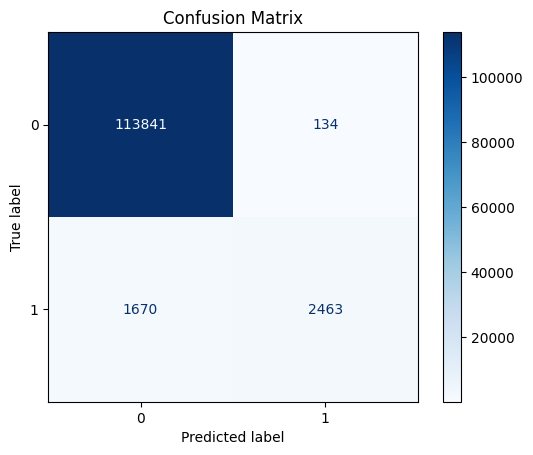

In [ ]:
# Predictions on training data
y_train_pred = final_model.predict(X_train_final)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = final_model.predict(X_val)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [9]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    score_mean = 0
    for tr_idx, val_idx in skf.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, 
            random_state=4, 
            tree_method='hist', 
            device='cuda', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict_proba(X_vl)[:, 1]  # Get the predicted probabilities for the positive class
        score = roc_auc_score(y_vl, y_pred)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
}

In [10]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30, 
            # trials=trials
           )

                                                      
############## New Run ################
params = {'max_depth': 18, 'gamma': '0.241', 'subsample': '0.40', 'reg_alpha': '0.286', 'reg_lambda': '0.137', 'learning_rate': '0.056', 'colsample_bytree': '0.566'}
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [09:43:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



1 CV - score: 0.969                                   
2 CV - score: 0.9719                                  
3 CV - score: 0.9661                                  
4 CV - score: 0.9665                                  
5 CV - score: 0.9706                                  
6 CV - score: 0.9701                                  
7 CV - score: 0.969                                   
Total Time Run: 6.18                                  
Mean ROC_AUC: 0.9690284843903019                      
                                                                                    
############## New Run ################
params = {'max_depth': 12, 'gamma': '0.532', 'subsample': '0.80', 'reg_alpha': '0.206', 'reg_lambda': '0.102', 'learning_rate': '0.045', 'colsample_bytree': '0.400'}
1 CV - score: 0.972                                                                 
2 CV - score: 0.9744                                                                
3 CV - score: 0.9706                        

In [11]:
from hyperopt import space_eval

best_params = space_eval(space, best)
best_params

{'colsample_bytree': 0.7768566940145034,
 'gamma': 0.2699340698522061,
 'learning_rate': 0.04429196603072367,
 'max_depth': 15.0,
 'reg_alpha': 0.3855341538606946,
 'reg_lambda': 0.24642750491032303,
 'subsample': 0.9}

In [16]:
print("BEST PARAMS: ", best_params)
best_params['max_depth'] = int(best_params['max_depth'])

clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='hist', 
    device='cuda', 
)

clf.fit(X_train_final, y_train_final)

BEST PARAMS:  {'colsample_bytree': 0.7768566940145034, 'gamma': 0.2699340698522061, 'learning_rate': 0.04429196603072367, 'max_depth': 15, 'reg_alpha': 0.3855341538606946, 'reg_lambda': 0.24642750491032303, 'subsample': 0.9}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7768566940145034, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.2699340698522061, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04429196603072367,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Training Performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    455902
           1       1.00      0.90      0.95     16530

    accuracy                           1.00    472432
   macro avg       1.00      0.95      0.97    472432
weighted avg       1.00      1.00      1.00    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.96      0.62      0.75      4133

    accuracy                           0.99    118108
   macro avg       0.97      0.81      0.87    118108
weighted avg       0.99      0.99      0.98    118108



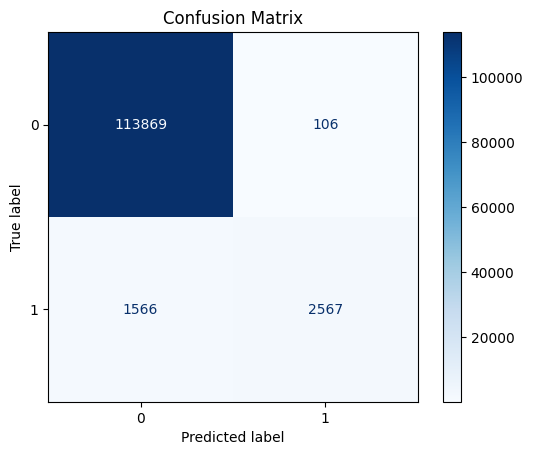

In [17]:
# Predictions on training data
y_train_pred = clf.predict(X_train_final)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = clf.predict(X_val)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [14]:
X_train.shape

(590540, 236)

Nizsie su vysledky s pouzitim PCA (n_components = 100), ked som nepouzil PCA, cize to malo 218 features tak vysledok f1_score bol 0.75, cize nie je velky rozdiel

Training Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    455902
           1       0.99      0.84      0.91     16530

    accuracy                           0.99    472432
   macro avg       0.99      0.92      0.95    472432
weighted avg       0.99      0.99      0.99    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.93      0.60      0.73      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.80      0.86    118108
weighted avg       0.98      0.98      0.98    118108



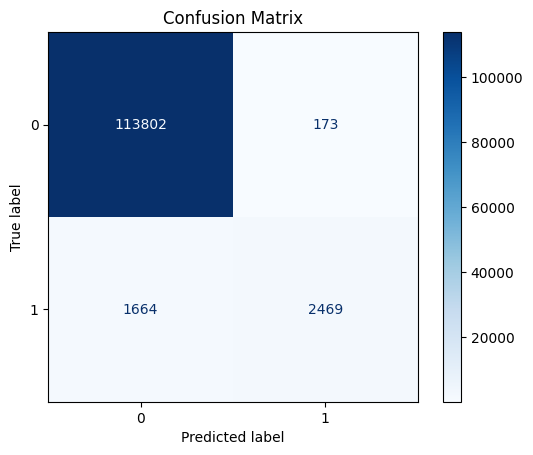

In [13]:
# Predictions on training data
y_train_pred = final_model.predict(X_train_final)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = final_model.predict(X_val)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [14]:
print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  F1 Score: 0.984122104759035
  Best hyperparameters:
    n_estimators: 98
    max_depth: 18
    reg_alpha: 0.2696886456176707
    reg_lambda: 0.014254118814841827
    learning_rate: 0.16608431929319323
    colsample_bytree: 0.6986386790117205
    gamma: 0.024185267166715707
    subsample: 0.9


In [43]:
print("Best hyperparameters:", study.best_params)


Best hyperparameters: {'max_depth': 7, 'reg_alpha': 0.2946159224553781, 'reg_lambda': 0.1361386597387954, 'learning_rate': 0.14993445814599607, 'colsample_bytree': 0.4730683643096283, 'gamma': 0.21539724804975374, 'subsample': 0.7}


In [30]:
X_train_pca.shape

(590540, 50)

In [ ]:
#toto teraz pustam

In [20]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    tss = TimeSeriesSplit(n_splits=FOLDS)

    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, 
            random_state=4, 
            tree_method='hist', 
            device='cuda', 
            eval_metric='auc',
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict_proba(X_vl)[:, 1]  # Get the predicted probabilities for the positive class
        score = roc_auc_score(y_vl, y_pred)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
}

In [21]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

# Print best parameters
best_params = space_eval(space, best)

                                                      
############## New Run ################
params = {'max_depth': 14, 'gamma': '0.066', 'subsample': '0.70', 'reg_alpha': '0.166', 'reg_lambda': '0.136', 'learning_rate': '0.063', 'colsample_bytree': '0.374'}
1 CV - score: 0.9002                                  
2 CV - score: 0.9064                                  
3 CV - score: 0.9206                                  
4 CV - score: 0.893                                   
5 CV - score: 0.9315                                  
6 CV - score: 0.9245                                  
7 CV - score: 0.9152                                  
Total Time Run: 3.76                                  
Mean ROC_AUC: 0.9130521108857871                      
                                                                                    
############## New Run ################
params = {'max_depth': 13, 'gamma': '0.125', 'subsample': '0.20', 'reg_alpha': '0.070', 'reg_lambda': '0.030', 'learnin


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    113975
           1       1.00      0.87      0.93      4133

    accuracy                           1.00    118108
   macro avg       1.00      0.93      0.96    118108
weighted avg       1.00      1.00      1.00    118108



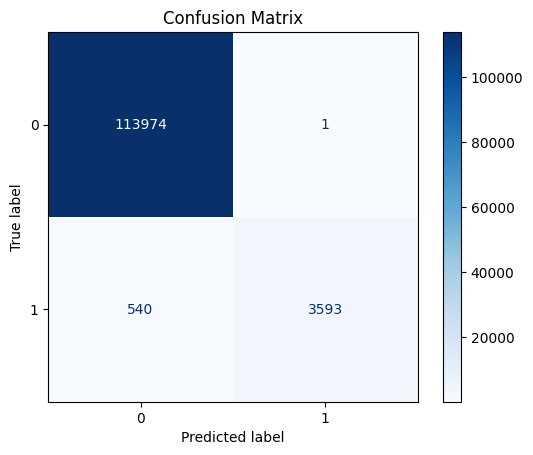

In [24]:
final_params = {
    'max_depth': int(best_params['max_depth']),
    'reg_alpha': float("{:.3f}".format(best_params['reg_alpha'])),
    'reg_lambda': float("{:.3f}".format(best_params['reg_lambda'])),
    'learning_rate': float("{:.3f}".format(best_params['learning_rate'])),
    'colsample_bytree': float("{:.3f}".format(best_params['colsample_bytree'])),
    'gamma': float("{:.3f}".format(best_params['gamma'])),
    'subsample': best_params['subsample'],  # Already selected as a float from choice
}

# Train model with best parameters on full training set
clf_model = xgb.XGBClassifier(
    n_estimators=600,
    random_state=4,
    tree_method='hist',  # As per XGBoost >=2.0 best practice
    device='cuda',
    eval_metric='auc',
    **final_params
)

# Fit on full training set
clf_model.fit(X_train, y_train)

# Predict on your test/validation set (make sure y_val exists)
y_val_pred = clf_model.predict(X_val)

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Tu su vysledky s pouzitim custom function objective

In [14]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    tss = TimeSeriesSplit(n_splits=FOLDS)

    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, 
            random_state=4, 
            tree_method='hist', 
            device='cuda', 
            eval_metric='auc',
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict_proba(X_vl)[:, 1]  # Get the predicted probabilities for the positive class
        score = roc_auc_score(y_vl, y_pred)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
}

In [15]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

# Print best parameters
best_params = space_eval(space, best)

                                                      
############## New Run ################
params = {'max_depth': 15, 'gamma': '0.294', 'subsample': '0.70', 'reg_alpha': '0.031', 'reg_lambda': '0.309', 'learning_rate': '0.103', 'colsample_bytree': '0.721'}
1 CV - score: 0.8915                                  
2 CV - score: 0.8966                                  
3 CV - score: 0.9153                                  
4 CV - score: 0.8814                                  
5 CV - score: 0.9222                                  
6 CV - score: 0.9175                                  
7 CV - score: 0.9094                                  
Total Time Run: 2.29                                  
Mean ROC_AUC: 0.9048348306010251                      
                                                                                  
############## New Run ################
params = {'max_depth': 17, 'gamma': '0.445', 'subsample': '0.60', 'reg_alpha': '0.063', 'reg_lambda': '0.237', 'learning_

In [22]:
print("BEST PARAMS: ", best_params)
best_params['max_depth'] = int(best_params['max_depth'])

clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='hist', 
    device='cuda', 
)

clf.fit(X_train, y_train)

BEST PARAMS:  {'colsample_bytree': 0.5339422540810459, 'gamma': 0.6295947244162987, 'learning_rate': 0.010413793991159775, 'max_depth': 19.0, 'reg_alpha': 0.22955833954630991, 'reg_lambda': 0.18324643801402007, 'subsample': 0.8}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5339422540810459, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.6295947244162987, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010413793991159775,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Training Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    455902
           1       1.00      0.75      0.85     16530

    accuracy                           0.99    472432
   macro avg       0.99      0.87      0.93    472432
weighted avg       0.99      0.99      0.99    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    113975
           1       1.00      0.77      0.87      4133

    accuracy                           0.99    118108
   macro avg       0.99      0.88      0.93    118108
weighted avg       0.99      0.99      0.99    118108



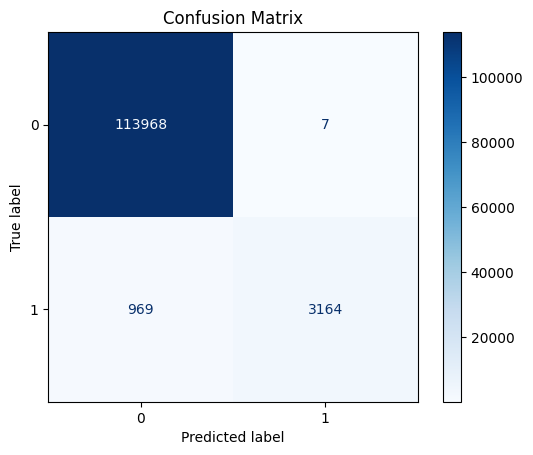

In [23]:
# Predictions on training data
y_train_pred = clf.predict(X_train_final)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = clf.predict(X_val)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [18]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

,score
TransactionID,70547.0
card1,56658.0
TransactionAmt,53572.0
card2,51959.0
TransactionDT,50510.0
addr1,36859.0
P_emaildomain,21310.0
card5,20990.0
D15,18715.0
C13,16062.0



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    113975
           1       1.00      0.90      0.94      4133

    accuracy                           1.00    118108
   macro avg       1.00      0.95      0.97    118108
weighted avg       1.00      1.00      1.00    118108



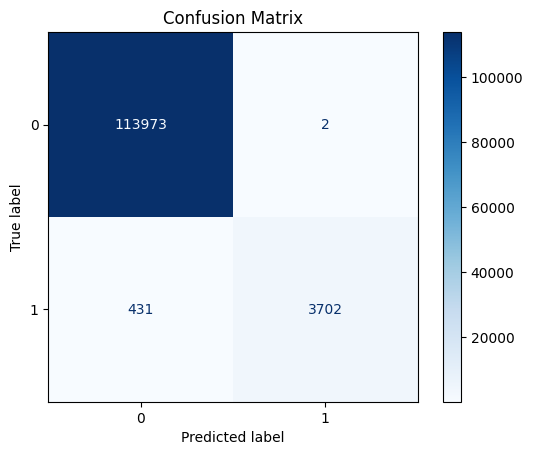

In [ ]:
final_params = {
    'max_depth': int(best_params['max_depth']),
    'reg_alpha': float("{:.3f}".format(best_params['reg_alpha'])),
    'reg_lambda': float("{:.3f}".format(best_params['reg_lambda'])),
    'learning_rate': float("{:.3f}".format(best_params['learning_rate'])),
    'colsample_bytree': float("{:.3f}".format(best_params['colsample_bytree'])),
    'gamma': float("{:.3f}".format(best_params['gamma'])),
    'subsample': best_params['subsample'],  # Already selected as a float from choice
}

# Train model with best parameters on full training set
final_model = xgb.XGBClassifier(
    n_estimators=600,
    random_state=4,
    tree_method='hist',  # As per XGBoost >=2.0 best practice
    device='cuda',
    eval_metric='auc',
    **final_params
)

# Fit on full training set
final_model.fit(X_train, y_train)

# Predict on your test/validation set (make sure y_val exists)
y_val_pred = final_model.predict(X_val)

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()